# **Projet 7: Implémenter un modèle de scoring**

# **Construction du modèle**

# Preselection des variables
### Kernel Kaggle: **LightGBM with Simple Features**
https://www.kaggle.com/code/jsaguiar/lightgbm-with-simple-features  

### Modèle du script original
Le script original utilisait une approche exhaustive pour déterminer l'importance des features dans la prédiction du scoring de crédit. Avec plus de 700 features, le modèle offre une vue détaillée mais complexe des facteurs influençant le scoring de crédit.  
### Notre Approche pour la Simplification
Il est nécessaire de simplifié le script en pour nous concentrer uniquement sur les 50 features les plus importantes, identifiées par le modèle LightGBM du script original.


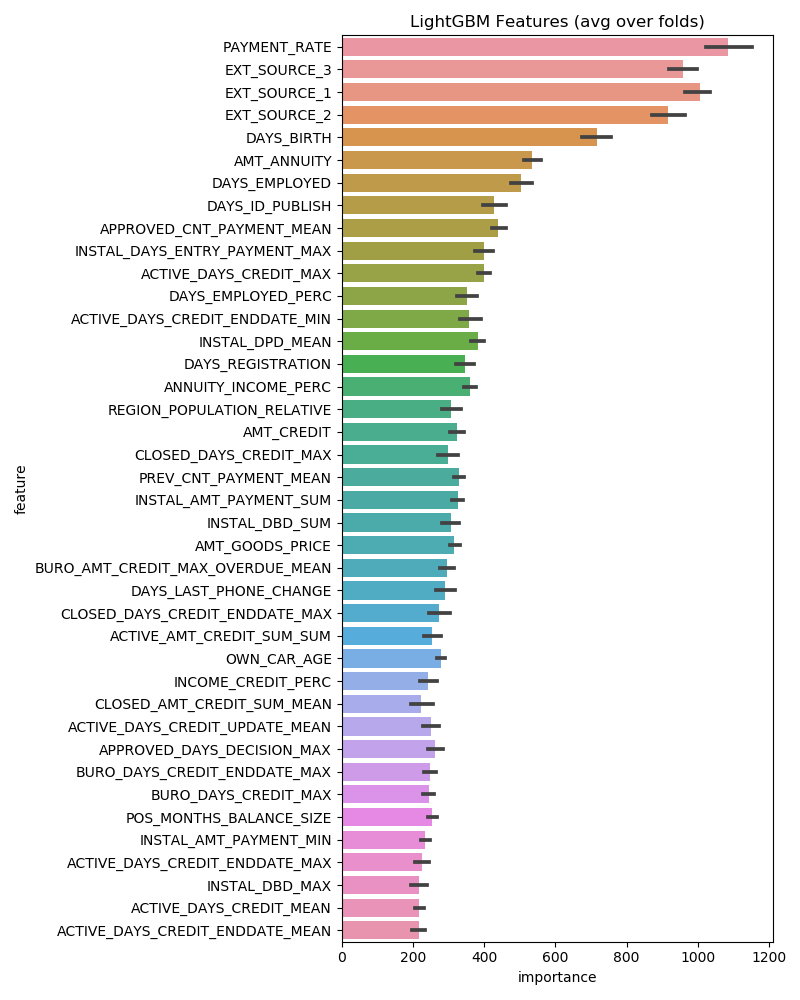

## Script adapté pour la création du nouveau dataset

### Fichiers de Données Utilisés
1. **application_train.csv et application_test.csv** : Contiennent les données des demandes de crédit, incluant des informations personnelles, financières et sur les précédents crédits des clients.
2. **bureau.csv et bureau_balance.csv** : Fournissent des détails sur les crédits antérieurs des clients auprès d'autres institutions financières.
3. **previous_application.csv** : Inclut les données sur les demandes de crédit antérieures des clients auprès de la même institution.
4. **POS_CASH_balance.csv** : Contient des informations sur les crédits renouvelables et les paiements mensuels.
5. **installments_payments.csv** : Détaille les historiques de remboursement des crédits précédents.

### Opérations Principales
1. **Agrégation de Données** : Calcul de statistiques résumées (comme le maximum, la moyenne, etc.) pour obtenir des insights pertinents à partir des données brutes.
2. **Fusion des Données** : Combinaison des informations de différents fichiers en un seul DataFrame pour faciliter l'analyse et le modèle prédictif.
3. **Création de Nouvelles Features** : Développement de nouvelles variables (comme le pourcentage d'emploi par rapport à l'âge) pour améliorer la puissance prédictive du modèle.

Cette approche ciblée assure que nous utilisons uniquement les données les plus pertinentes pour notre modèle, ce qui améliore l'efficacité et la performance tout en réduisant la complexité et le temps de traitement.


In [1]:
# script simplifié de https://www.kaggle.com/jsaguiar/lightgbm-with-simple-features
# préparation des données pour la création du modèle de scoring
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df,cols, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = cols
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = False):
    df = pd.read_csv('../input/application_train.csv', nrows= num_rows)
    test_df = pd.read_csv('../input/application_test.csv', nrows= num_rows)
    df = pd.concat([df, test_df], ignore_index=True)
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df

# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv('../input/bureau.csv', nrows = num_rows)
    bureau_cat = ['CREDIT_ACTIVE']
    bureau, bureau_cat = one_hot_encoder(bureau, bureau_cat, nan_as_category)
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['max', 'mean'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['mean', 'sum'],

    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv('../input/previous_application.csv', nrows = num_rows)
    cat_cols = ['NAME_CONTRACT_STATUS']
    prev, cat_cols = one_hot_encoder(prev, cat_cols, nan_as_category= True)
    num_aggregations = {
        'DAYS_DECISION': ['max'],
        'CNT_PAYMENT': ['mean'],
    }
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']    
        prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    del approved, approved_agg, prev
    gc.collect()
    return prev_agg

# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv('../input/POS_CASH_balance.csv', nrows = num_rows)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'size'],
    }
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg
    
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv('../input/installments_payments.csv', nrows = num_rows)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_DIFF': [ 'var'],
        'AMT_PAYMENT': ['min'],
        'DAYS_ENTRY_PAYMENT': ['max']
    }
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

# séparation des fichier application_train et application_test
def séparation_train_test(df):
    # Divide in training/validation and test data
    appli_train_df = df[df['TARGET'].notnull()]
    appli_test_df = df[df['TARGET'].isnull()]
    # sauvegarde des fichiers
    appli_train_df.to_csv('appli_train_df.csv', index=False)
    appli_test_df.to_csv('appli_test_df.csv', index=False)
    return appli_train_df, appli_test_df

# fonction principale
def main(debug = False):
    num_rows = 10000 if debug else None
    df = application_train_test(num_rows)
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
# sauvegarde du fichier
    df.to_csv('df.csv', index=False)
    with timer("Séparation train test"):
        appli_train_df, appli_test_df = séparation_train_test(df)       
        print("Train shape: {}, test shape: {}".format(appli_train_df.shape, appli_test_df.shape))

if __name__ == "__main__":
    submission_file_name = "submission_kernel02.csv"
    with timer("Full model run"):
        main()

Bureau df shape: (305811, 38)
Process bureau and bureau_balance - done in 4s
Previous applications df shape: (338857, 9)
Process previous_applications - done in 8s
Pos-cash balance df shape: (337252, 3)
Process POS-CASH balance - done in 5s
Installments payments df shape: (339587, 7)
Process installments payments - done in 13s
Train shape: (307511, 184), test shape: (48744, 184)
Séparation train test - done in 62s
Full model run - done in 136s


# Exploration du nouveau Dataset
### Kernel Kaggle comme point de départ: 
### **Start Here: A Gentle Introduction**

## Biblitohèques

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# importer les données
data = pd.read_csv("appli_train_df.csv") # uniquement les données qui ont un target
#data = pd.read_csv("df.csv")
data.shape

(307511, 184)

## Fonction utile

In [3]:
def classify_columns(df):
    binary_cols = [col for col in df.columns if df[col].nunique() == 2]
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    categorical_cols = [col for col in categorical_cols if col not in binary_cols]
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    numeric_cols = [col for col in numeric_cols if col not in binary_cols]

    return categorical_cols, numeric_cols, binary_cols

## Identification des variables
En plus de ces features clés, les features `NAME_HOUSING_TYPE`, `NAME_FAMILY_STATUS`, et `OCCUPATION_TYPE` sont incluses pour enrichir notre compréhension du profil client.

In [4]:
application_features = [
    'DAYS_BIRTH','DAYS_EMPLOYED','DAYS_EMPLOYED_PERC', 
    'DAYS_LAST_PHONE_CHANGE','DAYS_ID_PUBLISH','DAYS_REGISTRATION',
    'REGION_POPULATION_RELATIVE','NAME_HOUSING_TYPE','NAME_FAMILY_STATUS',
 #   'CODE_GENDER','AMT_CREDIT',
    'OCCUPATION_TYPE','FLAG_OWN_CAR','FLAG_OWN_REALTY',
    'INCOME_PER_PERSON','INCOME_CREDIT_PERC','ANNUITY_INCOME_PERC',
    'PAYMENT_RATE','AMT_ANNUITY','AMT_GOODS_PRICE','AMT_INCOME_TOTAL',
    'EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3'
]

bureau_features = [
    'CLOSED_DAYS_CREDIT_ENDDATE_MAX','CLOSED_DAYS_CREDIT_MAX', 
    'CLOSED_AMT_CREDIT_SUM_MEAN', 
    'ACTIVE_DAYS_CREDIT_ENDDATE_MEAN','ACTIVE_DAYS_CREDIT_ENDDATE_MAX',
    'ACTIVE_DAYS_CREDIT_ENDDATE_MIN','ACTIVE_DAYS_CREDIT_MEAN',
    'ACTIVE_DAYS_CREDIT_UPDATE_MEAN',
    'ACTIVE_AMT_CREDIT_SUM_SUM',
    'BURO_DAYS_CREDIT_ENDDATE_MAX','BURO_DAYS_CREDIT_MAX',
    'BURO_AMT_CREDIT_MAX_OVERDUE_MEAN'
]
others_features = [
    'APPROVED_CNT_PAYMENT_MEAN',
    'APPROVED_DAYS_DECISION_MAX',
 #   'HOUR_APPR_PROCESS_START',
    'PREV_CNT_PAYMENT_MEAN',
    'POS_MONTHS_BALANCE_SIZE',
    'POS_MONTHS_BALANCE_MAX',
    'INSTAL_DBD_MAX','INSTAL_DBD_SUM','INSTAL_DBD_MEAN',
    'INSTAL_AMT_PAYMENT_MIN',
    'INSTAL_DAYS_ENTRY_PAYMENT_MAX',
    'INSTAL_PAYMENT_DIFF_VAR',
    'OWN_CAR_AGE','OBS_30_CNT_SOCIAL_CIRCLE',
]

In [5]:
# créattion df avec les features
data = data[application_features + bureau_features + others_features + ['TARGET']]
data.shape

(307511, 48)

In [6]:
pd.set_option('display.max_columns', 500)
data.head()

,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_EMPLOYED_PERC,DAYS_LAST_PHONE_CHANGE,DAYS_ID_PUBLISH,DAYS_REGISTRATION,REGION_POPULATION_RELATIVE,NAME_HOUSING_TYPE,NAME_FAMILY_STATUS,OCCUPATION_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,INCOME_PER_PERSON,INCOME_CREDIT_PERC,ANNUITY_INCOME_PERC,PAYMENT_RATE,AMT_ANNUITY,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,CLOSED_DAYS_CREDIT_ENDDATE_MAX,CLOSED_DAYS_CREDIT_MAX,CLOSED_AMT_CREDIT_SUM_MEAN,ACTIVE_DAYS_CREDIT_ENDDATE_MEAN,ACTIVE_DAYS_CREDIT_ENDDATE_MAX,ACTIVE_DAYS_CREDIT_ENDDATE_MIN,ACTIVE_DAYS_CREDIT_MEAN,ACTIVE_DAYS_CREDIT_UPDATE_MEAN,ACTIVE_AMT_CREDIT_SUM_SUM,BURO_DAYS_CREDIT_ENDDATE_MAX,BURO_DAYS_CREDIT_MAX,BURO_AMT_CREDIT_MAX_OVERDUE_MEAN,APPROVED_CNT_PAYMENT_MEAN,APPROVED_DAYS_DECISION_MAX,PREV_CNT_PAYMENT_MEAN,POS_MONTHS_BALANCE_SIZE,POS_MONTHS_BALANCE_MAX,INSTAL_DBD_MAX,INSTAL_DBD_SUM,INSTAL_DBD_MEAN,INSTAL_AMT_PAYMENT_MIN,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_PAYMENT_DIFF_VAR,OWN_CAR_AGE,OBS_30_CNT_SOCIAL_CIRCLE,TARGET
0,-9461,-637.0,0.067329,-1134.0,-2120,-3648.0,0.018801,House / apartment,Single / not married,Laborers,N,Y,202500.0,0.498036,0.121978,0.060749,24700.5,351000.0,202500.0,0.083037,0.262949,0.139376,85.0,-476.0,63844.5,780.0,780.0,780.0,-572.5,-15.5,481988.565,780.0,-103.0,1681.029,24.000000,-606.0,24.000000,19.0,-1.0,31.0,388.0,20.421053,9251.775,-49.0,0.000000e+00,NaN,2.0,1.0
1,-16765,-1188.0,0.070862,-828.0,-291,-1186.0,0.003541,House / apartment,Married,Core staff,N,N,135000.0,0.208736,0.132217,0.027598,35698.5,1129500.0,270000.0,0.311267,0.622246,NaN,-420.0,-775.0,69133.5,1216.0,1216.0,1216.0,-606.0,-43.0,810000.000,1216.0,-606.0,0.000,10.000000,-746.0,10.000000,28.0,-18.0,14.0,179.0,7.160000,6662.970,-544.0,0.000000e+00,NaN,1.0,0.0
2,-19046,-225.0,0.011814,-815.0,-2531,-4260.0,0.010032,House / apartment,Single / not married,Laborers,Y,Y,67500.0,0.500000,0.100000,0.050000,6750.0,135000.0,67500.0,NaN,0.555912,0.729567,-382.0,-408.0,94518.9,NaN,NaN,NaN,NaN,NaN,NaN,-382.0,-408.0,0.000,4.000000,-815.0,4.000000,4.0,-24.0,11.0,23.0,7.666667,5357.250,-727.0,0.000000e+00,26.0,0.0,0.0
3,-19005,-3039.0,0.159905,-617.0,-2437,-9833.0,0.008019,House / apartment,Civil marriage,Laborers,N,Y,67500.0,0.431748,0.219900,0.094941,29686.5,297000.0,135000.0,NaN,0.650442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.000000,-181.0,23.000000,21.0,-1.0,77.0,310.0,19.375000,2482.920,-12.0,0.000000e+00,NaN,2.0,0.0
4,-19932,-3038.0,0.152418,-1106.0,-3458,-4311.0,0.028663,House / apartment,Single / not married,Core staff,N,Y,121500.0,0.236842,0.179963,0.042623,21865.5,513000.0,121500.0,NaN,0.322738,NaN,-783.0,-1149.0,146250.0,NaN,NaN,NaN,NaN,NaN,NaN,-783.0,-1149.0,0.000,20.666667,-374.0,20.666667,66.0,-1.0,31.0,303.0,4.590909,0.180,-14.0,8.084830e+06,NaN,0.0,0.0


In [7]:
cat_cols, num_cols, bin_cols = classify_columns(data)
print('Categorical columns: {}'.format(cat_cols))
print('Numeric columns: {}'.format(num_cols))
print('Binary columns: {}'.format(bin_cols))

Categorical columns: ['NAME_HOUSING_TYPE', 'NAME_FAMILY_STATUS', 'OCCUPATION_TYPE']
Numeric columns: ['DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_EMPLOYED_PERC', 'DAYS_LAST_PHONE_CHANGE', 'DAYS_ID_PUBLISH', 'DAYS_REGISTRATION', 'REGION_POPULATION_RELATIVE', 'INCOME_PER_PERSON', 'INCOME_CREDIT_PERC', 'ANNUITY_INCOME_PERC', 'PAYMENT_RATE', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'AMT_INCOME_TOTAL', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'CLOSED_DAYS_CREDIT_ENDDATE_MAX', 'CLOSED_DAYS_CREDIT_MAX', 'CLOSED_AMT_CREDIT_SUM_MEAN', 'ACTIVE_DAYS_CREDIT_ENDDATE_MEAN', 'ACTIVE_DAYS_CREDIT_ENDDATE_MAX', 'ACTIVE_DAYS_CREDIT_ENDDATE_MIN', 'ACTIVE_DAYS_CREDIT_MEAN', 'ACTIVE_DAYS_CREDIT_UPDATE_MEAN', 'ACTIVE_AMT_CREDIT_SUM_SUM', 'BURO_DAYS_CREDIT_ENDDATE_MAX', 'BURO_DAYS_CREDIT_MAX', 'BURO_AMT_CREDIT_MAX_OVERDUE_MEAN', 'APPROVED_CNT_PAYMENT_MEAN', 'APPROVED_DAYS_DECISION_MAX', 'PREV_CNT_PAYMENT_MEAN', 'POS_MONTHS_BALANCE_SIZE', 'POS_MONTHS_BALANCE_MAX', 'INSTAL_DBD_MAX', 'INSTAL_DBD_SUM', 'INSTAL_DBD_MEAN'

## Analyse statistique

### Variable catégorielles

In [8]:
# valeurs unique de 'CODE_GENDER'
#data['CODE_GENDER'].value_counts()

Imputation par 'F' pour les 4 valeurs manquantes de 'CODE_GENDER' pour une transformation en binaire

In [9]:
# remplace XNA par F
#data['CODE_GENDER'].replace('XNA', 'F', inplace=True)

#### Les catégorielles multiple

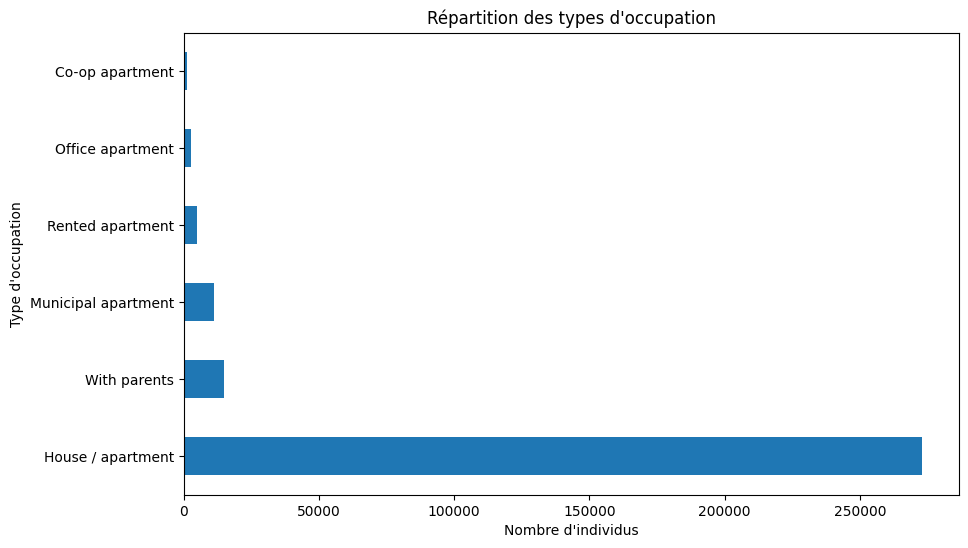

In [10]:
occupation_counts = data['NAME_HOUSING_TYPE'].value_counts()

# Tracez un graphique à barres horizontales
plt.figure(figsize=(10, 6)) 
occupation_counts.plot(kind='barh') 

plt.xlabel('Nombre d\'individus')
plt.ylabel('Type d\'occupation')
plt.title('Répartition des types d\'occupation')
plt.show()

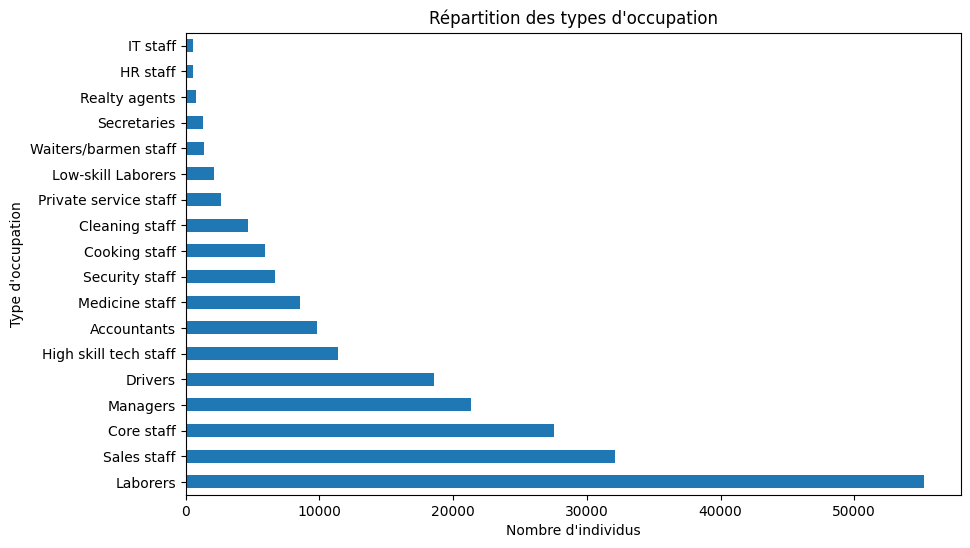

In [11]:
occupation_counts = data['OCCUPATION_TYPE'].value_counts()

# Tracez un graphique à barres horizontales
plt.figure(figsize=(10, 6)) 
occupation_counts.plot(kind='barh') 

plt.xlabel('Nombre d\'individus')
plt.ylabel('Type d\'occupation')
plt.title('Répartition des types d\'occupation')
plt.show()

#### Les catégorielles binaires

In [12]:

def plot_pie_chart(data, labels):
    counts = data.value_counts()
    plt.figure(figsize=(6, 6))  
    plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title('Repartition des individus pour {}'.format(data.name))

    plt.show()

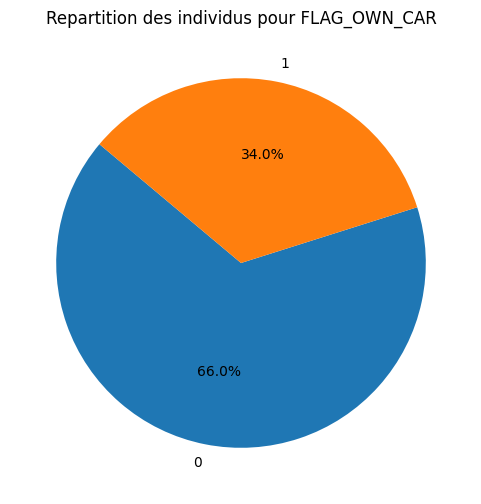

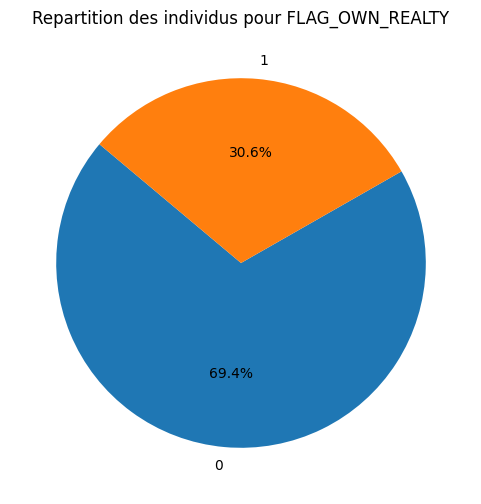

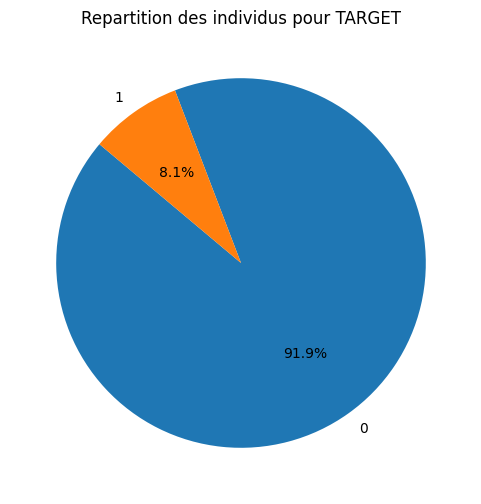

In [13]:
for col in bin_cols:
    plot_pie_chart(data[col], [0, 1])


On note ici un fort déséquilibre entre les deux classes de la variable cible

### Variable numériques temporelles

In [14]:
days_cols = [col for col in data.columns if 'DAYS' in col]  
days_cols

['DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_EMPLOYED_PERC',
 'DAYS_LAST_PHONE_CHANGE',
 'DAYS_ID_PUBLISH',
 'DAYS_REGISTRATION',
 'CLOSED_DAYS_CREDIT_ENDDATE_MAX',
 'CLOSED_DAYS_CREDIT_MAX',
 'ACTIVE_DAYS_CREDIT_ENDDATE_MEAN',
 'ACTIVE_DAYS_CREDIT_ENDDATE_MAX',
 'ACTIVE_DAYS_CREDIT_ENDDATE_MIN',
 'ACTIVE_DAYS_CREDIT_MEAN',
 'ACTIVE_DAYS_CREDIT_UPDATE_MEAN',
 'BURO_DAYS_CREDIT_ENDDATE_MAX',
 'BURO_DAYS_CREDIT_MAX',
 'APPROVED_DAYS_DECISION_MAX',
 'INSTAL_DAYS_ENTRY_PAYMENT_MAX']

In [15]:
# statistiques descriptives
data[days_cols].describe()

,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_EMPLOYED_PERC,DAYS_LAST_PHONE_CHANGE,DAYS_ID_PUBLISH,DAYS_REGISTRATION,CLOSED_DAYS_CREDIT_ENDDATE_MAX,CLOSED_DAYS_CREDIT_MAX,ACTIVE_DAYS_CREDIT_ENDDATE_MEAN,ACTIVE_DAYS_CREDIT_ENDDATE_MAX,ACTIVE_DAYS_CREDIT_ENDDATE_MIN,ACTIVE_DAYS_CREDIT_MEAN,ACTIVE_DAYS_CREDIT_UPDATE_MEAN,BURO_DAYS_CREDIT_ENDDATE_MAX,BURO_DAYS_CREDIT_MAX,APPROVED_DAYS_DECISION_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MAX
count,307511.000000,252137.000000,252137.000000,307510.000000,307511.000000,307511.000000,228643.000000,230165.000000,208187.000000,208187.000000,208187.000000,217150.000000,217150.000000,261242.000000,263491.000000,290065.000000,291635.000000
mean,-16036.995067,-2384.169325,0.156861,-962.858788,-2994.202373,-4986.120328,774.743285,-907.441340,2480.875306,4755.175424,1011.900618,-650.789789,-132.196563,4433.041953,-489.297817,-603.058528,-327.784607
std,4363.988632,2338.360162,0.133549,826.808487,1509.450419,3522.886321,5052.998772,641.321946,5509.124782,9381.650365,4687.684645,495.737551,295.449235,9350.942497,537.574145,564.019818,536.868180
min,-25229.000000,-17912.000000,-0.000000,-4292.000000,-7197.000000,-24672.000000,-41875.000000,-2922.000000,-41874.000000,-41874.000000,-42056.000000,-2922.000000,-41919.000000,-41875.000000,-2922.000000,-2922.000000,-3071.000000
25%,-19682.000000,-3175.000000,0.056099,-1570.000000,-4299.000000,-7479.500000,-627.000000,-1198.000000,269.000000,495.000000,-14.000000,-871.500000,-113.833333,125.000000,-620.000000,-731.000000,-384.000000
50%,-15750.000000,-1648.000000,0.118733,-757.000000,-3254.000000,-4504.000000,-211.000000,-729.000000,716.500000,1051.000000,252.000000,-537.309524,-30.000000,909.000000,-300.000000,-434.000000,-66.000000
75%,-12413.000000,-767.000000,0.219170,-274.000000,-1720.000000,-2010.000000,122.000000,-437.000000,1412.000000,1711.000000,769.000000,-294.425000,-16.500000,1683.000000,-143.000000,-244.000000,-26.000000
max,-7489.000000,0.000000,0.728811,0.000000,0.000000,0.000000,31198.000000,0.000000,31198.000000,31199.000000,31198.000000,0.000000,372.000000,31199.000000,0.000000,-1.000000,-1.000000


On remarque des date très lointaines dans les colonnes 'ACTIVE_DAYS_CREDIT' et 'CLOSED_DAYS_CREDIT': **Plus de 114 ans**  
Alors que l'age maximum est des individus est de 69 ans.

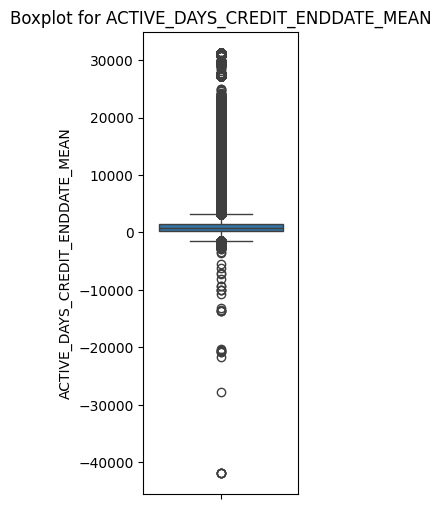

count    208187.000000
mean       2480.875306
std        5509.124782
min      -41874.000000
25%         269.000000
50%         716.500000
75%        1412.000000
max       31198.000000
Name: ACTIVE_DAYS_CREDIT_ENDDATE_MEAN, dtype: float64


In [16]:
def plot_individual_boxplot(df, column):
    plt.figure(figsize=(2, 6))
    sns.boxplot(y=df[column])
    plt.title(f"Boxplot for {column}")
    plt.show()

    # Affichage des statistiques descriptives
    print(df[column].describe())

# Exemple d'utilisation pour une variable spécifique
plot_individual_boxplot(data, 'ACTIVE_DAYS_CREDIT_ENDDATE_MEAN')  # Remplacer par le nom de la variable d'intérêt


Une solution sera de remplacer les valeurs aberrantes par une valeur max en utilisant la méthode des quartiles

In [17]:
# une solution sera de remplacer les valeurs aberrantes par une valeur max en utilisant la méthode des quartiles
def replace_outliers(df, column):
    # Calcul des quartiles
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    # Calcul de l'IQR
    iqr = q3 - q1
    # Remplacement des valeurs aberrantes par la valeur max
    df.loc[df[column] > q3 + 1.5 * iqr, column] = q3 + 1.5 * iqr
    return df

list_col_outlier = ['ACTIVE_DAYS_CREDIT_ENDDATE_MEAN','ACTIVE_DAYS_CREDIT_ENDDATE_MAX',
                    'ACTIVE_DAYS_CREDIT_ENDDATE_MIN','ACTIVE_DAYS_CREDIT_MEAN',
                    'ACTIVE_DAYS_CREDIT_UPDATE_MEAN',
                    'CLOSED_DAYS_CREDIT_ENDDATE_MAX','CLOSED_DAYS_CREDIT_MAX']

### Valeur numériques

In [18]:
non_days_cols = [col for col in num_cols if col not in days_cols]
data[non_days_cols].describe()

,REGION_POPULATION_RELATIVE,INCOME_PER_PERSON,INCOME_CREDIT_PERC,ANNUITY_INCOME_PERC,PAYMENT_RATE,AMT_ANNUITY,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,CLOSED_AMT_CREDIT_SUM_MEAN,ACTIVE_AMT_CREDIT_SUM_SUM,BURO_AMT_CREDIT_MAX_OVERDUE_MEAN,APPROVED_CNT_PAYMENT_MEAN,PREV_CNT_PAYMENT_MEAN,POS_MONTHS_BALANCE_SIZE,POS_MONTHS_BALANCE_MAX,INSTAL_DBD_MAX,INSTAL_DBD_SUM,INSTAL_DBD_MEAN,INSTAL_AMT_PAYMENT_MIN,INSTAL_PAYMENT_DIFF_VAR,OWN_CAR_AGE,OBS_30_CNT_SOCIAL_CIRCLE
count,307511.000000,3.075090e+05,307511.000000,307499.000000,307499.000000,307499.000000,3.072330e+05,3.075110e+05,134133.000000,3.068510e+05,246546.000000,2.301650e+05,2.171500e+05,1.838860e+05,290065.000000,290642.000000,289444.000000,289444.000000,291643.000000,291643.000000,291643.000000,2.916350e+05,2.909470e+05,104582.000000,306490.000000
mean,0.020868,9.310588e+04,0.399670,0.180930,0.053695,27108.573909,5.383962e+05,1.687979e+05,0.502130,5.143927e-01,0.510853,2.576505e+05,1.311231e+06,5.242425e+03,13.592943,14.530822,29.516504,-12.560709,37.849329,390.654190,12.265713,5.198133e+03,3.430758e+08,12.061091,1.422245
std,0.013831,1.013734e+05,0.507924,0.094574,0.022481,14493.737315,3.694465e+05,2.371231e+05,0.211062,1.910602e-01,0.194844,8.046181e+05,2.365918e+06,3.064082e+05,7.543960,8.419878,24.304535,18.662888,28.967778,405.166931,9.142536,1.442452e+04,3.494272e+09,11.944812,2.400989
min,0.000290,2.812500e+03,0.011801,0.000224,0.022073,1615.500000,4.050000e+04,2.565000e+04,0.014568,8.173617e-08,0.000527,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,1.000000,-96.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,0.010006,4.725000e+04,0.193803,0.114782,0.036900,16524.000000,2.385000e+05,1.125000e+05,0.334007,3.924574e-01,0.370650,6.868938e+04,2.340000e+05,0.000000e+00,9.000000,9.000000,12.000000,-15.000000,23.000000,133.000000,6.672414,4.099500e+01,0.000000e+00,5.000000,0.000000
50%,0.018850,7.500000e+04,0.306272,0.162833,0.050000,24903.000000,4.500000e+05,1.471500e+05,0.505998,5.659614e-01,0.535276,1.251000e+05,6.479244e+05,0.000000e+00,12.000000,12.000000,22.000000,-4.000000,31.000000,266.000000,10.119048,2.314800e+03,0.000000e+00,9.000000,0.000000
75%,0.028663,1.125000e+05,0.495376,0.229067,0.064043,34596.000000,6.795000e+05,2.025000e+05,0.675053,6.636171e-01,0.669057,2.533404e+05,1.525499e+06,2.124000e+03,17.142857,18.000000,39.000000,-2.000000,43.000000,507.000000,15.138889,7.105748e+03,1.124217e+07,15.000000,2.000000
max,0.072508,3.900000e+07,208.003328,1.875965,0.124430,258025.500000,4.050000e+06,1.170000e+08,0.962693,8.549997e-01,0.896010,1.980723e+08,3.347397e+08,1.159872e+08,72.000000,72.000000,295.000000,-1.000000,3189.000000,10529.000000,295.000000,2.504590e+06,4.459936e+11,91.000000,348.000000


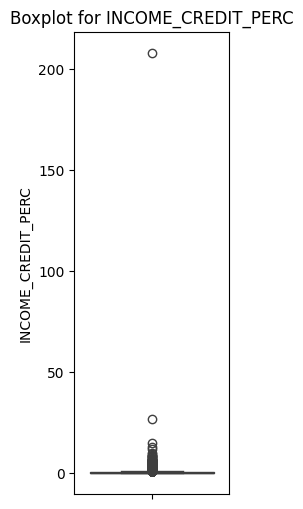

count    307511.000000
mean          0.399670
std           0.507924
min           0.011801
25%           0.193803
50%           0.306272
75%           0.495376
max         208.003328
Name: INCOME_CREDIT_PERC, dtype: float64


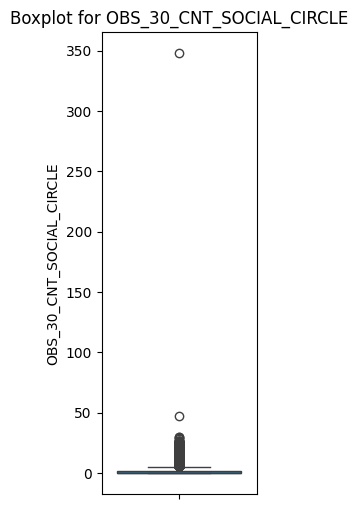

count    306490.000000
mean          1.422245
std           2.400989
min           0.000000
25%           0.000000
50%           0.000000
75%           2.000000
max         348.000000
Name: OBS_30_CNT_SOCIAL_CIRCLE, dtype: float64


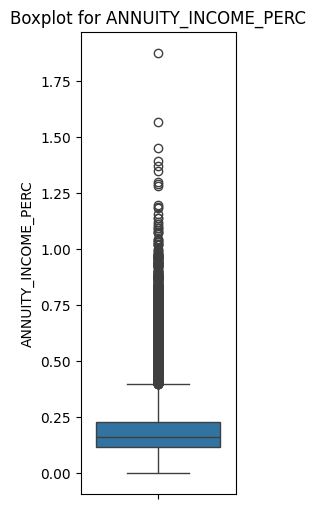

count    307499.000000
mean          0.180930
std           0.094574
min           0.000224
25%           0.114782
50%           0.162833
75%           0.229067
max           1.875965
Name: ANNUITY_INCOME_PERC, dtype: float64


In [19]:
# box plot pour les variables numériques INCOME_CREDIT_PERC, ANNUITY_INCOME_PERC,OBS_30_CNT_SOCIAL_CIRCLE
plot_individual_boxplot(data, 'INCOME_CREDIT_PERC')
plot_individual_boxplot(data, 'OBS_30_CNT_SOCIAL_CIRCLE')
plot_individual_boxplot(data, 'ANNUITY_INCOME_PERC')

In [20]:
# affichage des lignes avec des valeur supérieurs à 1
pd.set_option('display.max_columns', None)
data[data['ANNUITY_INCOME_PERC'] > 1.5]

,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_EMPLOYED_PERC,DAYS_LAST_PHONE_CHANGE,DAYS_ID_PUBLISH,DAYS_REGISTRATION,REGION_POPULATION_RELATIVE,NAME_HOUSING_TYPE,NAME_FAMILY_STATUS,OCCUPATION_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,INCOME_PER_PERSON,INCOME_CREDIT_PERC,ANNUITY_INCOME_PERC,PAYMENT_RATE,AMT_ANNUITY,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,CLOSED_DAYS_CREDIT_ENDDATE_MAX,CLOSED_DAYS_CREDIT_MAX,CLOSED_AMT_CREDIT_SUM_MEAN,ACTIVE_DAYS_CREDIT_ENDDATE_MEAN,ACTIVE_DAYS_CREDIT_ENDDATE_MAX,ACTIVE_DAYS_CREDIT_ENDDATE_MIN,ACTIVE_DAYS_CREDIT_MEAN,ACTIVE_DAYS_CREDIT_UPDATE_MEAN,ACTIVE_AMT_CREDIT_SUM_SUM,BURO_DAYS_CREDIT_ENDDATE_MAX,BURO_DAYS_CREDIT_MAX,BURO_AMT_CREDIT_MAX_OVERDUE_MEAN,APPROVED_CNT_PAYMENT_MEAN,APPROVED_DAYS_DECISION_MAX,PREV_CNT_PAYMENT_MEAN,POS_MONTHS_BALANCE_SIZE,POS_MONTHS_BALANCE_MAX,INSTAL_DBD_MAX,INSTAL_DBD_SUM,INSTAL_DBD_MEAN,INSTAL_AMT_PAYMENT_MIN,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_PAYMENT_DIFF_VAR,OWN_CAR_AGE,OBS_30_CNT_SOCIAL_CIRCLE,TARGET
20727,-21517,NaN,NaN,-677.0,-4962,-1669.0,0.035792,House / apartment,Civil marriage,NaN,Y,Y,12825.0,0.011801,1.875965,0.022139,48118.5,2173500.0,25650.0,0.498675,0.175965,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.00,-254.0,36.666667,16.0,-1.0,32.0,145.0,10.357143,2229.795,-11.0,8.127915e+08,2.0,2.0,1.0
197677,-23087,NaN,NaN,0.0,-4289,-13967.0,0.020246,House / apartment,Married,NaN,N,Y,22500.0,0.060563,1.570600,0.095120,70677.0,688500.0,45000.0,0.682304,0.045469,0.701696,94.0,-636.0,84645.0,NaN,NaN,NaN,NaN,NaN,NaN,94.0,-636.0,0.0,12.25,-419.0,12.250000,89.0,-3.0,58.0,1007.0,11.709302,75.600,-97.0,8.905883e+07,NaN,0.0,0.0


C:\Users\fathi\AppData\Local\Temp\ipykernel_9176\3530824340.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['POS_MONTHS_BALANCE_SIZE'], bins=50, kde=False)


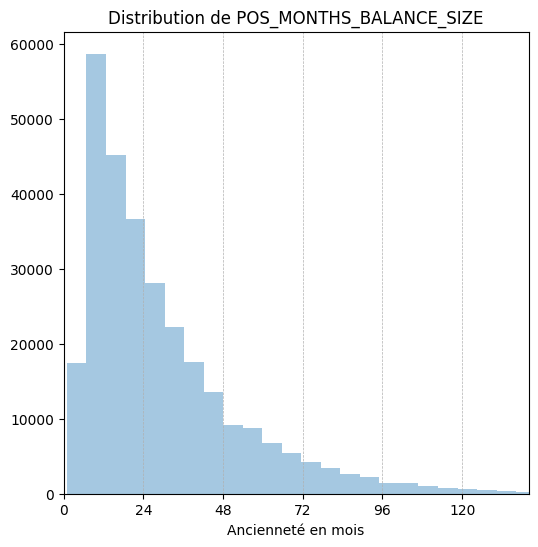

In [21]:
# Affichage de la distribution de la variable POS_MONTHS_BALANCE_SIZE
plt.figure(figsize=(6, 6))

sns.distplot(data['POS_MONTHS_BALANCE_SIZE'], bins=50, kde=False)

# Limiter à 140 mois pour une meilleure visualisation
plt.xlim(0, 140)

plt.title('Distribution de POS_MONTHS_BALANCE_SIZE')

# Définir les ticks tous les 24 mois (tous les 2 ans)
plt.xticks(np.arange(0, 140, step=24),fontsize=10)
plt.xlabel('Ancienneté en mois', fontsize=10)
# Ajouter une grille
plt.grid(True, which='both', axis='x', linestyle='--', linewidth=0.5)


# Afficher le graphique
plt.show()

### Traitement des outliers

In [22]:
list_col_outlier = ['ACTIVE_DAYS_CREDIT_ENDDATE_MEAN', 'ACTIVE_DAYS_CREDIT_ENDDATE_MAX',
                    'ACTIVE_DAYS_CREDIT_ENDDATE_MIN', 'ACTIVE_DAYS_CREDIT_MEAN',
                    'ACTIVE_DAYS_CREDIT_UPDATE_MEAN', 'CLOSED_DAYS_CREDIT_ENDDATE_MAX',
                    'CLOSED_DAYS_CREDIT_MAX','INCOME_CREDIT_PERC','OBS_30_CNT_SOCIAL_CIRCLE']

In [23]:
for col in list_col_outlier:
    data = replace_outliers(data, col) 

## Correlation entre les variables

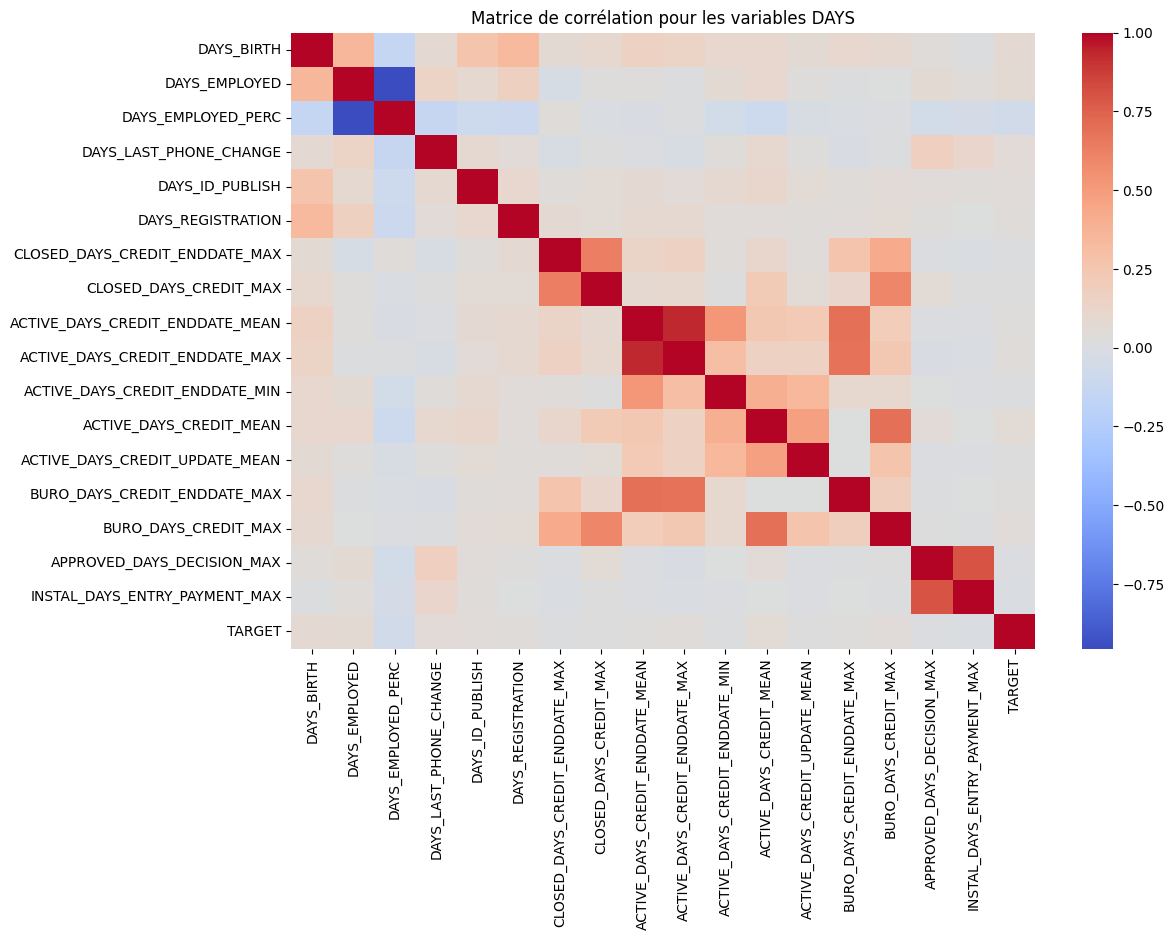

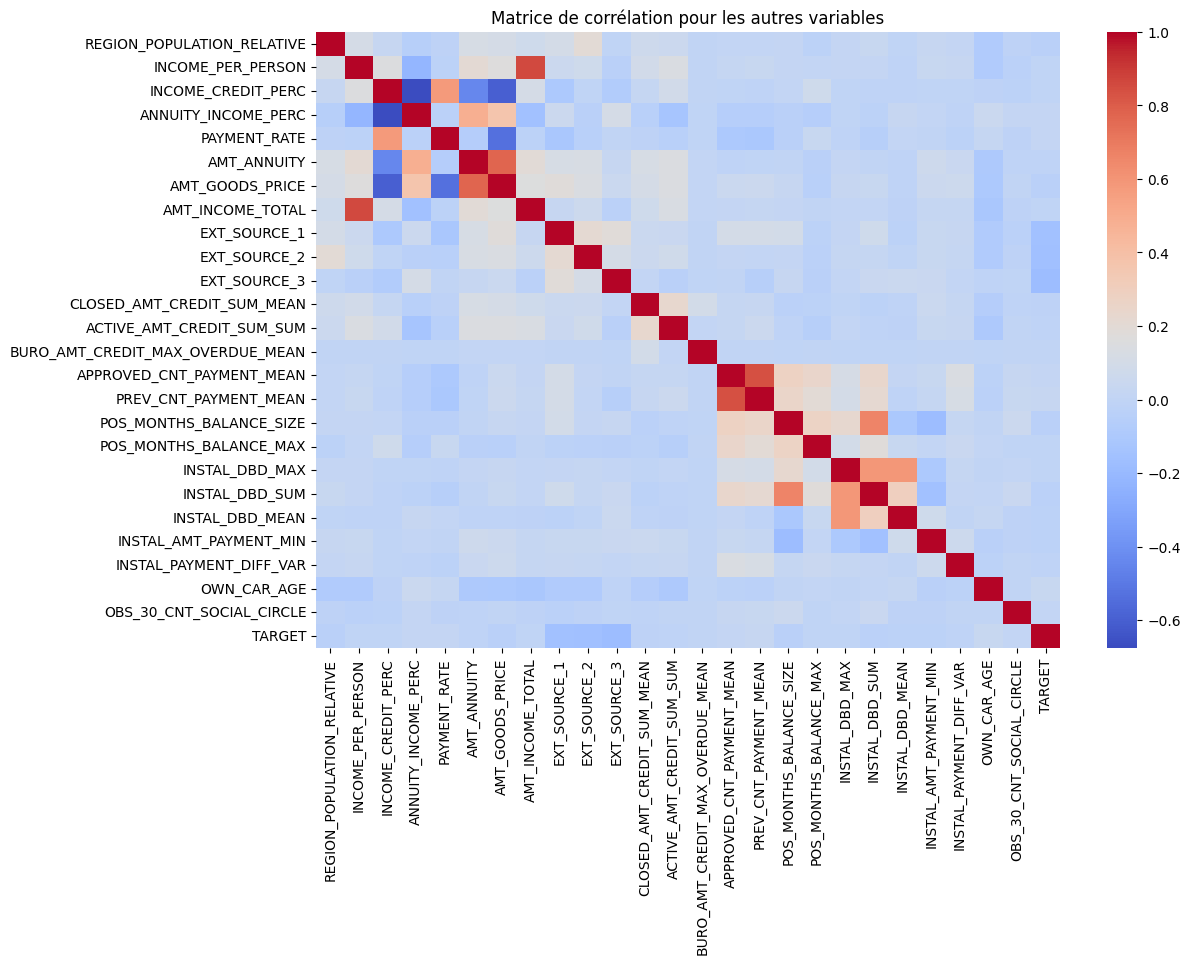

In [24]:
target_column = 'TARGET'

def plot_correlation_matrix(df, feature_list, title):
    # Ajout de la variable cible à la liste si elle n'est pas déjà présente
    if target_column not in feature_list:
        feature_list = feature_list + [target_column]

    # Sélection des colonnes numériques, y compris la cible
    numeric_cols = df[feature_list].select_dtypes(include=[np.number]).columns.tolist()
    correlation_matrix = df[numeric_cols].corr()

    # Création et affichage de la heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(correlation_matrix, annot=False, fmt='.2f', cmap='coolwarm')
    plt.title(title)
    plt.show()

plot_correlation_matrix(data, days_cols, "Matrice de corrélation pour les variables DAYS")
plot_correlation_matrix(data, non_days_cols, "Matrice de corrélation pour les autres variables")

les variables les plus corrélé avec la variable cible sont les variables EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3
Certaines variables sont parfaitement corrélées entre elles, ce qui peut poser problème pour certains algorithmes de machine learning. Nous testerons l'effet de la suppression de ces variables sur les performances des modèles.

## Traitement des valeurs manquantes
### Imputation par zéro d'une sélection de varaibles

In [25]:

# Calculer le nombre de valeurs manquantes pour chaque colonne
missing_data = data[days_cols].isnull().sum().sort_values(ascending=False)

# Créer un DataFrame pour stocker ces informations
missing_data_df = pd.DataFrame({'missing': missing_data})
missing_data_df['missing%'] = missing_data_df['missing'] / data.shape[0]

# Trier le DataFrame en fonction du pourcentage de valeurs manquantes
missing_data_df.sort_values(by='missing%', ascending=False)


missing_data_df

,missing,missing%
ACTIVE_DAYS_CREDIT_ENDDATE_MEAN,99324,0.322993
ACTIVE_DAYS_CREDIT_ENDDATE_MAX,99324,0.322993
ACTIVE_DAYS_CREDIT_ENDDATE_MIN,99324,0.322993
ACTIVE_DAYS_CREDIT_UPDATE_MEAN,90361,0.293846
ACTIVE_DAYS_CREDIT_MEAN,90361,0.293846
CLOSED_DAYS_CREDIT_ENDDATE_MAX,78868,0.256472
CLOSED_DAYS_CREDIT_MAX,77346,0.251523
DAYS_EMPLOYED_PERC,55374,0.180072
DAYS_EMPLOYED,55374,0.180072
BURO_DAYS_CREDIT_ENDDATE_MAX,46269,0.150463


In [26]:
# liste de colonne avec les plus de valeurs manquantes dans l'order croissant de non_days_cols
missing_data__2 = data[non_days_cols].isnull().sum().sort_values(ascending=False)

# Créer un DataFrame pour stocker ces informations
missing_data_df_2 = pd.DataFrame({'missing': missing_data__2})
missing_data_df_2['missing%'] = missing_data_df_2['missing'] / data.shape[0]

# Calculer le pourcentage moyen de TARGET pour les lignes où chaque colonne est manquante
        
# Trier le DataFrame en fonction du pourcentage de valeurs manquantes
missing_data_df_2.sort_values(by='missing%', ascending=False)

missing_data_df_2

,missing,missing%
OWN_CAR_AGE,202929,0.659908
EXT_SOURCE_1,173378,0.563811
BURO_AMT_CREDIT_MAX_OVERDUE_MEAN,123625,0.402018
ACTIVE_AMT_CREDIT_SUM_SUM,90361,0.293846
CLOSED_AMT_CREDIT_SUM_MEAN,77346,0.251523
EXT_SOURCE_3,60965,0.198253
POS_MONTHS_BALANCE_MAX,18067,0.058752
POS_MONTHS_BALANCE_SIZE,18067,0.058752
APPROVED_CNT_PAYMENT_MEAN,17446,0.056733
PREV_CNT_PAYMENT_MEAN,16869,0.054857


In [27]:
iterative_impute_features = ['DAYS_EMPLOYED_PERC','DAYS_EMPLOYED',
                            'AMT_GOODS_PRICE','AMT_ANNUITY','PAYMENT_RATE',
                            'ANNUITY_INCOME_PERC','INCOME_PER_PERSON',
#                            'EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3'#,
#                            'DAYS_LAST_PHONE_CHANGE','AMT_CREDIT','OBS_30_CNT_SOCIAL_CIRCLE',
#                            'OWN_CAR_AGE','HOUR_APPR_PROCESS_START',
#                            'INSTAL_DBD_MAX','INSTAL_DBD_SUM','INSTAL_DBD_MEAN',
#                            'INSTAL_AMT_PAYMENT_MIN','INSTAL_DAYS_ENTRY_PAYMENT_MAX',
#                            'INSTAL_PAYMENT_DIFF_VAR',
#                            'ACTIVE_DAYS_CREDIT_ENDDATE_MEAN','ACTIVE_DAYS_CREDIT_ENDDATE_MAX',
#                            'ACTIVE_DAYS_CREDIT_ENDDATE_MIN','ACTIVE_DAYS_CREDIT_MEAN',
#                            'ACTIVE_DAYS_CREDIT_UPDATE_MEAN','ACTIVE_AMT_CREDIT_SUM_SUM',
#                            'CLOSED_DAYS_CREDIT_ENDDATE_MAX','CLOSED_DAYS_CREDIT_MAX',
#                            'CLOSED_AMT_CREDIT_SUM_MEAN','BURO_DAYS_CREDIT_ENDDATE_MAX',
#                            'BURO_DAYS_CREDIT_MAX','BURO_AMT_CREDIT_MAX_OVERDUE_MEAN',
#                            'BURO_AMT_CREDIT_MAX_OVERDUE_MEAN','PREV_CNT_PAYMENT_MEAN',
#                            'POS_MONTHS_BALANCE_SIZE','POS_MONTHS_BALANCE_MAX',
#                            'APPROVED_CNT_PAYMENT_MEAN','APPROVED_DAYS_DECISION_MAX'
                            ]

In [28]:
# toutes les autres colonnes seront imputées par la moyenne
mean_impute_features = [col for col in num_cols if col not in iterative_impute_features]

# imputation par la moyenne
for col in mean_impute_features:
    data[col].fillna(data[col].mean(), inplace=True)                   

# Entrainement des modèles

In [29]:
# sauvegarde du fichier
data.to_csv('data_mean.csv', index=False)
# chargement du fichier
data_mean = pd.read_csv("data_mean.csv")
data_mean.shape

(307511, 48)

## Transformation et normalisation des données

In [30]:
# Echantillonage des données
#data_sample = data_mean.sample(frac=0.2, random_state=42)
#data_sample.shape

In [31]:
cat_cols, num_cols, bin_cols = classify_columns(data_mean)

In [32]:
# nous allons créer une liste des colonnes qui seront normalisées
def sup_1 (df):
    liste = []
    for col in num_cols:
        if df[col].max() > 1 or df[col].min() < -1:
            liste.append(col)            
    return liste

cols_to_normalize = sup_1(data_mean)
print(cols_to_normalize)
print(bin_cols)

['DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_LAST_PHONE_CHANGE', 'DAYS_ID_PUBLISH', 'DAYS_REGISTRATION', 'INCOME_PER_PERSON', 'ANNUITY_INCOME_PERC', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'AMT_INCOME_TOTAL', 'CLOSED_DAYS_CREDIT_ENDDATE_MAX', 'CLOSED_DAYS_CREDIT_MAX', 'CLOSED_AMT_CREDIT_SUM_MEAN', 'ACTIVE_DAYS_CREDIT_ENDDATE_MEAN', 'ACTIVE_DAYS_CREDIT_ENDDATE_MAX', 'ACTIVE_DAYS_CREDIT_ENDDATE_MIN', 'ACTIVE_DAYS_CREDIT_MEAN', 'ACTIVE_DAYS_CREDIT_UPDATE_MEAN', 'ACTIVE_AMT_CREDIT_SUM_SUM', 'BURO_DAYS_CREDIT_ENDDATE_MAX', 'BURO_DAYS_CREDIT_MAX', 'BURO_AMT_CREDIT_MAX_OVERDUE_MEAN', 'APPROVED_CNT_PAYMENT_MEAN', 'APPROVED_DAYS_DECISION_MAX', 'PREV_CNT_PAYMENT_MEAN', 'POS_MONTHS_BALANCE_SIZE', 'POS_MONTHS_BALANCE_MAX', 'INSTAL_DBD_MAX', 'INSTAL_DBD_SUM', 'INSTAL_DBD_MEAN', 'INSTAL_AMT_PAYMENT_MIN', 'INSTAL_DAYS_ENTRY_PAYMENT_MAX', 'INSTAL_PAYMENT_DIFF_VAR', 'OWN_CAR_AGE', 'OBS_30_CNT_SOCIAL_CIRCLE']
['FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'TARGET']


In [33]:
# label encoding
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for col in bin_cols:
    data_mean[col] = le.fit_transform(data_mean[col])

In [34]:
from sklearn.experimental import enable_iterative_imputer

from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler

# séparation des données en train et test
from sklearn.model_selection import train_test_split
train, test = train_test_split(data_mean, test_size=0.2, random_state=42)

# séparation des données en X et y
X_train = train.drop('TARGET', axis=1)
y_train = train['TARGET']
X_test = test.drop('TARGET', axis=1)
y_test = test['TARGET']

In [35]:
# OHE sur les colonnes catégorielles
from sklearn.preprocessing import OneHotEncoder

# Initialisation de OneHotEncoder
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')

# Application de OneHotEncoder aux colonnes catégorielles
# Fit sur X_train et transforme X_train et X_test
X_train_ohe = ohe.fit_transform(X_train[cat_cols])
X_test_ohe = ohe.transform(X_test[cat_cols])

# Création de DataFrame à partir des sorties OHE
ohe_cols = ohe.get_feature_names_out(cat_cols)
X_train_ohe = pd.DataFrame(X_train_ohe, columns=ohe_cols, index=X_train.index)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=ohe_cols, index=X_test.index)

# Concaténation des colonnes OHE aux données originales après suppression des colonnes catégorielles
X_train = pd.concat([X_train.drop(cat_cols, axis=1), X_train_ohe], axis=1)
X_test = pd.concat([X_test.drop(cat_cols, axis=1), X_test_ohe], axis=1)

In [36]:

column_names = X_train.columns  # Sauvegarder les noms des colonnes

# Traitement des valeurs manquantes avec itérative imputer pour les colonnes spécifiées
imputer = IterativeImputer(max_iter=10, random_state=42)
X_train_imputed = imputer.fit_transform(X_train[iterative_impute_features])
X_test_imputed = imputer.transform(X_test[iterative_impute_features])

# Mise à jour des colonnes imputées dans X_train et X_test
X_train[iterative_impute_features] = X_train_imputed
X_test[iterative_impute_features] = X_test_imputed

# Normalisation des données
scaler = StandardScaler()
X_train[cols_to_normalize] = scaler.fit_transform(X_train[cols_to_normalize])
X_test[cols_to_normalize] = scaler.transform(X_test[cols_to_normalize])

In [37]:
# sauvegarde des fichiers pour les tests de mise en production
X_train.to_csv('X_train.csv', index=False)
y_train.to_csv('y_train.csv', index=False)
X_test.to_csv('X_test.csv', index=False)
y_test.to_csv('y_test.csv', index=False)

X_train.shape, y_train.shape, X_test.shape, y_test.shape   

((246008, 75), (246008,), (61503, 75), (61503,))

In [38]:
# paramètres d'affichage
pd.set_option('display.max_columns', 78)
X_train.describe()

,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_EMPLOYED_PERC,DAYS_LAST_PHONE_CHANGE,DAYS_ID_PUBLISH,DAYS_REGISTRATION,REGION_POPULATION_RELATIVE,FLAG_OWN_CAR,FLAG_OWN_REALTY,INCOME_PER_PERSON,INCOME_CREDIT_PERC,ANNUITY_INCOME_PERC,PAYMENT_RATE,AMT_ANNUITY,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,CLOSED_DAYS_CREDIT_ENDDATE_MAX,CLOSED_DAYS_CREDIT_MAX,CLOSED_AMT_CREDIT_SUM_MEAN,ACTIVE_DAYS_CREDIT_ENDDATE_MEAN,ACTIVE_DAYS_CREDIT_ENDDATE_MAX,ACTIVE_DAYS_CREDIT_ENDDATE_MIN,ACTIVE_DAYS_CREDIT_MEAN,ACTIVE_DAYS_CREDIT_UPDATE_MEAN,ACTIVE_AMT_CREDIT_SUM_SUM,BURO_DAYS_CREDIT_ENDDATE_MAX,BURO_DAYS_CREDIT_MAX,BURO_AMT_CREDIT_MAX_OVERDUE_MEAN,APPROVED_CNT_PAYMENT_MEAN,APPROVED_DAYS_DECISION_MAX,PREV_CNT_PAYMENT_MEAN,POS_MONTHS_BALANCE_SIZE,POS_MONTHS_BALANCE_MAX,INSTAL_DBD_MAX,INSTAL_DBD_SUM,INSTAL_DBD_MEAN,INSTAL_AMT_PAYMENT_MIN,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_PAYMENT_DIFF_VAR,OWN_CAR_AGE,OBS_30_CNT_SOCIAL_CIRCLE,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,OCCUPATION_TYPE_nan
count,2.460080e+05,2.460080e+05,246008.000000,2.460080e+05,2.460080e+05,2.460080e+05,246008.000000,246008.000000,246008.000000,2.460080e+05,246008.000000,2.460080e+05,246008.000000,2.460080e+05,2.460080e+05,2.460080e+05,246008.000000,2.460080e+05,246008.000000,2.460080e+05,2.460080e+05,2.460080e+05,2.460080e+05,2.460080e+05,2.460080e+05,2.460080e+05,2.460080e+05,2.460080e+05,2.460080e+05,2.460080e+05,2.460080e+05,2.460080e+05,2.460080e+05,2.460080e+05,2.460080e+05,2.460080e+05,2.460080e+05,2.460080e+05,2.460080e+05,2.460080e+05,2.460080e+05,2.460080e+05,2.460080e+05,2.460080e+05,246008.000000,246008.000000,246008.000000,246008.000000,246008.000000,246008.000000,246008.000000,246008.000000,246008.000000,246008.000000,246008.000000,246008.000000,246008.000000,246008.000000,246008.000000,246008.000000,246008.00000,246008.000000,246008.000000,246008.000000,246008.000000,246008.000000,246008.000000,246008.000000,246008.000000,246008.000000,246008.000000,246008.000000,246008.000000,246008.000000,246008.000000
mean,1.587405e-16,-8.679315e-17,0.156599,-1.611811e-16,1.429415e-16,-1.995954e-16,0.020855,0.340741,0.694461,-1.089752e-16,0.373417,1.547510e-16,0.053680,-8.838171e-18,-8.561617e-17,1.965627e-16,0.502275,5.143846e-01,0.510998,1.805904e-17,7.076313e-19,-9.854849e-17,2.575363e-16,-4.081228e-16,3.167011e-17,-6.697947e-17,-4.419086e-18,-4.676865e-17,-1.397716e-16,6.624296e-17,-2.982161e-18,-1.782364e-16,1.882877e-16,-1.486892e-16,-3.696796e-16,4.101373e-18,-1.897030e-16,5.814130e-17,-4.247340e-16,-4.264201e-17,4.705026e-17,-1.171924e-17,1.961439e-16,1.484582e-16,0.003687,0.887731,0.036039,0.008504,0.015918,0.048120,0.096916,0.639491,0.064246,0.147434,0.000004,0.051909,0.031901,0.015130,0.019056,0.089599,0.06051,0.001817,0.037316,0.001671,0.179673,0.006736,0.069774,0.027710,0.008597,0.002423,0.104151,0.004305,0.021849,0.004354,0.313429
std,1.000002e+00,1.000002e+00,0.120976,1.000002e+00,1.000002e+00,1.000002e+00,0.013818,0.473959,0.460636,1.000002e+00,0.236033,1.000002e+00,0.022481,1.000002e+00,1.000002e+00,1.000002e+00,0.139346,1.908478e-01,0.174435,1.000002e+00,1.000002e+00,1.000002e+00,

In [39]:
X_train.head(10)

,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_EMPLOYED_PERC,DAYS_LAST_PHONE_CHANGE,DAYS_ID_PUBLISH,DAYS_REGISTRATION,REGION_POPULATION_RELATIVE,FLAG_OWN_CAR,FLAG_OWN_REALTY,INCOME_PER_PERSON,INCOME_CREDIT_PERC,ANNUITY_INCOME_PERC,PAYMENT_RATE,AMT_ANNUITY,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,CLOSED_DAYS_CREDIT_ENDDATE_MAX,CLOSED_DAYS_CREDIT_MAX,CLOSED_AMT_CREDIT_SUM_MEAN,ACTIVE_DAYS_CREDIT_ENDDATE_MEAN,ACTIVE_DAYS_CREDIT_ENDDATE_MAX,ACTIVE_DAYS_CREDIT_ENDDATE_MIN,ACTIVE_DAYS_CREDIT_MEAN,ACTIVE_DAYS_CREDIT_UPDATE_MEAN,ACTIVE_AMT_CREDIT_SUM_SUM,BURO_DAYS_CREDIT_ENDDATE_MAX,BURO_DAYS_CREDIT_MAX,BURO_AMT_CREDIT_MAX_OVERDUE_MEAN,APPROVED_CNT_PAYMENT_MEAN,APPROVED_DAYS_DECISION_MAX,PREV_CNT_PAYMENT_MEAN,POS_MONTHS_BALANCE_SIZE,POS_MONTHS_BALANCE_MAX,INSTAL_DBD_MAX,INSTAL_DBD_SUM,INSTAL_DBD_MEAN,INSTAL_AMT_PAYMENT_MIN,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_PAYMENT_DIFF_VAR,OWN_CAR_AGE,OBS_30_CNT_SOCIAL_CIRCLE,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,OCCUPATION_TYPE_nan
123473,-1.676136,-0.007050,0.151162,-1.323437,-0.937673,0.394791,0.035792,1,0,1.066796,0.307957,-0.900203,0.029475,-0.741100,-0.203354,0.024310,0.524685,0.358568,0.563835,-0.346236,-0.537722,-0.301167,-0.686521,-0.563221,-0.814545,-0.561809,-0.868818,-0.055339,-0.426161,-0.220422,-0.021176,1.304515,0.278448,1.052418,5.575214,0.637751,0.751868,6.184174,-0.204434,-0.359512,0.620913,-0.100800,2.724070,-0.729360,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
10118,1.173499,1.069649,0.010713,1.074968,-0.269054,0.199982,0.010032,0,1,-0.553054,0.795111,-0.325714,0.119335,-0.239945,-0.993872,-0.104840,0.244926,0.490305,0.595456,2.017027,0.369557,-0.268636,2.169088,2.051146,-1.354738,-0.115539,-0.548776,-0.415970,3.081605,0.396528,-0.021176,-0.582194,-0.510517,-0.737200,-0.191452,-0.411561,0.147786,-0.409731,-0.209051,-0.365155,-0.554169,-0.061725,0.000921,-0.131339,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
64716,-1.644952,0.106681,0.092922,-1.203819,-1.335928,-0.197305,0.035792,1,1,-0.348010,0.173901,0.058660,0.032427,-0.134194,0.295281,-0.320090,0.502130,0.643404,0.706205,-0.685710,-0.213050,-0.366595,0.000308,0.000346,0.000345,-0.000158,-0.000209,-0.001272,-0.598065,-1.076516,0.000181,0.097421,0.780683,-0.065002,3.794332,0.637751,2.315376,7.250649,2.204979,-0.238350,0.527289,-0.083869,-0.583007,0.466681,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
234940,1.223484,-0.069391,0.236382,0.521583,0.160347,0.672239,0.030755,1,1,-0.522831,0.182370,0.456607,0.040875,0.666226,0.976343,-0.041385,0.288642,0.426431,0.506484,-0.056240,0.668977,-0.325039,0.127315,0.027272,0.743485,0.571107,0.419326,0.323743,-0.353334,0.215664,-0.021176,0.172489,0.948703,0.790523,0.995803,0.582524,0.965074,0.773271,0.069601,-0.364508,0.559771,-0.100633,0.423495,-0.729360,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

## DummyClassifier
L'intérêt de ce modèle est de nous donner une baseline pour comparer les performances de nos modèles

Accuracy: 0.9195323805342829
Precision: 0.0
Recall: 0.0
F1: 0.0
ROC AUC: 0.5


c:\Users\fathi\anaconda3\envs\OCR_2\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


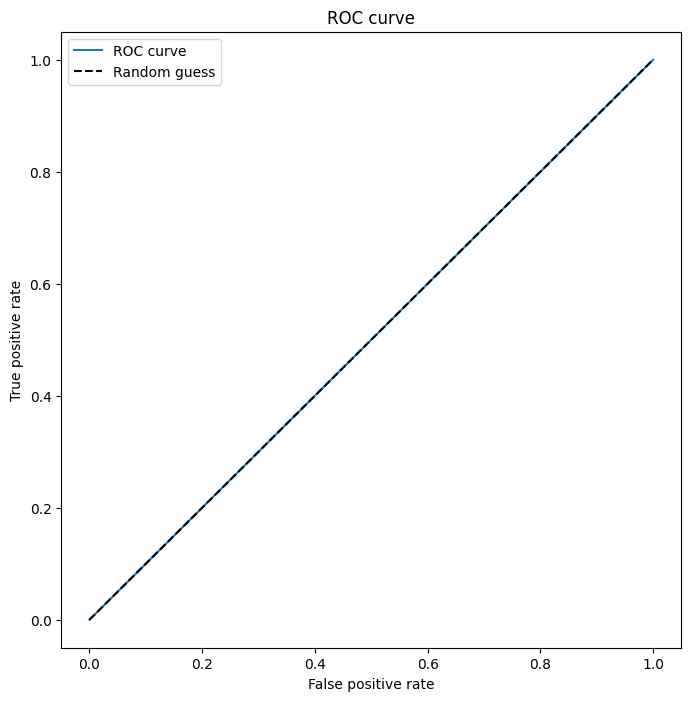

In [40]:
# Dummy classifier
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_test, y_test)

# Mesure de la performance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

def print_metrics(y_true, y_pred):
    print("Accuracy: {}".format(accuracy_score(y_true, y_pred)))
    print("Precision: {}".format(precision_score(y_true, y_pred)))
    print("Recall: {}".format(recall_score(y_true, y_pred)))
    print("F1: {}".format(f1_score(y_true, y_pred)))
    print("ROC AUC: {}".format(roc_auc_score(y_true, y_pred)))
    
def plot_roc_curve(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, label='ROC curve')
    plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend()
    plt.show()
    
    
print_metrics(y_test, dummy_clf.predict(X_test))
plot_roc_curve(y_test, dummy_clf.predict_proba(X_test)[:, 1])

In [41]:
def get_metrics(y_true, y_pred):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1": f1_score(y_true, y_pred),
        "ROC_AUC": roc_auc_score(y_true, y_pred)
    }

# Obtention des métriques pour le dummy classifier
metrics_dummy = get_metrics(y_test, dummy_clf.predict(X_test))
# Création d'un DataFrame pour stocker les résultats
results = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1', 'ROC_AUC'])

# Création d'une nouvelle ligne à ajouter
new_row = pd.DataFrame({'Model': 'Dummy Classifier', **metrics_dummy}, index=[0])
# Ajout des résultats du dummy classifier
results = pd.concat([results, new_row], ignore_index=True)
# Affichage des résultats
results


c:\Users\fathi\anaconda3\envs\OCR_2\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Model,Accuracy,Precision,Recall,F1,ROC_AUC
0,Dummy Classifier,0.919532,0.0,0.0,0.0,0.5


## LogisticRegression

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline

param_grid = {
    'model__C': [0.1, 1, 10],
    'model__penalty': ['l1', 'l2'],
    'model__solver': ['liblinear']
}

# GridSearchCV avec 5 folds
grid_search = GridSearchCV(
    Pipeline([
        ('model', LogisticRegression(solver='saga', penalty='elasticnet', max_iter=10000, random_state=42))
    ]),
    param_grid,
    cv=5,
    scoring='roc_auc',
    verbose=1,
    n_jobs=-1
)

# Entraînement sur le jeu d'entraînement
grid_search.fit(X_train, y_train)
# Meilleurs paramètres
print(grid_search.best_params_)
# Meilleur score
print(grid_search.best_score_)
# Meilleur modèle
best_model_linear = grid_search.best_estimator_
# Prédiction sur le jeu de test
y_pred_linear = best_model_linear.predict(X_test)

# Mesure de la performance
print_metrics(y_test, y_pred_linear)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
{'model__C': 10, 'model__penalty': 'l2', 'model__solver': 'liblinear'}
0.7455151360592241
Accuracy: 0.9194023055785897
Precision: 0.4666666666666667
Recall: 0.011315417256011316
F1: 0.022095087788518444
ROC AUC: 0.5050918777407121


In [43]:
# obtention des métriques
metrics_linear = get_metrics(y_test, y_pred_linear)
# Création d'une nouvelle ligne à ajouter
new_row = pd.DataFrame({'Model': 'Logistic Regression', **metrics_linear}, index=[0])
# Ajout des résultats de la régression logistique
results = pd.concat([results, new_row], ignore_index=True)
# Affichage des résultats
results

,Model,Accuracy,Precision,Recall,F1,ROC_AUC
0,Dummy Classifier,0.919532,0.000000,0.000000,0.000000,0.500000
1,Logistic Regression,0.919402,0.466667,0.011315,0.022095,0.505092


In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline

param_grid = {
    'model__C': [0.2,0.5],
    'model__penalty': ['l1', 'l2'],
    'model__solver': ['liblinear']
}

# GridSearchCV avec 5 folds et prise en compte de l'équilibre des classes
grid_search = GridSearchCV(
    Pipeline([
        ('model', LogisticRegression(solver='saga', penalty='elasticnet', class_weight='balanced', max_iter=10000, random_state=42))
    ]),
    param_grid,
    cv=5,
    scoring='roc_auc',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
# Meilleurs paramètres
print(grid_search.best_params_)
# Meilleur score
print(grid_search.best_score_)
# Meilleur modèle
best_model_linear_bal = grid_search.best_estimator_
# Prédiction sur le jeu de test
y_pred_linear_bal = best_model_linear_bal.predict(X_test)

# Mesure de la performance
print_metrics(y_test, y_pred_linear_bal)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
{'model__C': 0.5, 'model__penalty': 'l1', 'model__solver': 'liblinear'}
0.7453598742934694
Accuracy: 0.6862266881290343
Precision: 0.15937900583962397
Recall: 0.6783188522933926
F1: 0.25811164078117793
ROC AUC: 0.6826187747338873


In [45]:
# obtention des métriques
metrics_linear_bal = get_metrics(y_test, y_pred_linear_bal)
# Création d'une nouvelle ligne à ajouter
new_row = pd.DataFrame({'Model': 'Logistic Regression Balanced', **metrics_linear_bal}, index=[0])
# Ajout des résultats de la régression logistique
results = pd.concat([results, new_row], ignore_index=True)
results

,Model,Accuracy,Precision,Recall,F1,ROC_AUC
0,Dummy Classifier,0.919532,0.000000,0.000000,0.000000,0.500000
1,Logistic Regression,0.919402,0.466667,0.011315,0.022095,0.505092
2,Logistic Regression Balanced,0.686227,0.159379,0.678319,0.258112,0.682619


## LightGBM

In [46]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier

# Création du modèle LightGBM
model = LGBMClassifier(objective='binary', metric='binary_error', verbose=-1)

# Paramètres pour le GridSearchCV
param_grid = {
    'n_estimators': [200, 500, 1000],
    'learning_rate': [0.01, 0.1, 0.5]
}

# GridSearchCV pour la recherche des meilleurs paramètres
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train)

# Affichage des meilleurs paramètres et du meilleur score
print("Meilleurs paramètres : ", grid_search.best_params_)
print("Meilleur score : ", grid_search.best_score_)

# Prédiction et évaluation sur l'ensemble de test
best_model_lgb = grid_search.best_estimator_
y_pred_lgb = best_model_lgb.predict(X_test)
print_metrics(y_test, y_pred_lgb)

Meilleurs paramètres :  {'learning_rate': 0.01, 'n_estimators': 1000}
Meilleur score :  0.770808772639627
Accuracy: 0.9199713835097475
Precision: 0.5627906976744186
Recall: 0.02444938371388159
F1: 0.04686289697908597
ROC AUC: 0.5113936277412283


In [47]:
# obtention des métriques
metrics_lgb = get_metrics(y_test, y_pred_lgb)
# Création d'une nouvelle ligne à ajouter
new_row = pd.DataFrame({'Model': 'LightGBM', **metrics_lgb}, index=[0])
# Ajout des résultats de la régression logistique
results = pd.concat([results, new_row], ignore_index=True)
results

,Model,Accuracy,Precision,Recall,F1,ROC_AUC
0,Dummy Classifier,0.919532,0.000000,0.000000,0.000000,0.500000
1,Logistic Regression,0.919402,0.466667,0.011315,0.022095,0.505092
2,Logistic Regression Balanced,0.686227,0.159379,0.678319,0.258112,0.682619
3,LightGBM,0.919971,0.562791,0.024449,0.046863,0.511394


In [48]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier

# Création du modèle LightGBM avec rééquilibrage des classes
model = LGBMClassifier(objective='binary', class_weight='balanced', metric='binary_error', verbose=-1)

# Paramètres pour le GridSearchCV
param_grid = {
    'n_estimators': [200,500,1000],
    'learning_rate': [0.02]
}


# GridSearchCV pour la recherche des meilleurs paramètres
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train)

# Affichage des meilleurs paramètres et du meilleur score
print("Meilleurs paramètres : ", grid_search.best_params_)
print("Meilleur score : ", grid_search.best_score_)

# Prédiction et évaluation sur l'ensemble de test
best_model_lgb_bal = grid_search.best_estimator_
y_pred_lgb_bal = best_model_lgb_bal.predict(X_test)
print_metrics(y_test, y_pred_lgb_bal)

Meilleurs paramètres :  {'learning_rate': 0.02, 'n_estimators': 1000}
Meilleur score :  0.7725099958498246
Accuracy: 0.7343544217355251
Precision: 0.18536935742306204
Recall: 0.6779147302485351
F1: 0.2911315515446026
ROC AUC: 0.7086040744640136


In [49]:
# obtention des métriques
metrics_lgb_bal = get_metrics(y_test, y_pred_lgb_bal)
# Création d'une nouvelle ligne à ajouter
new_row = pd.DataFrame({'Model': 'LightGBM Balanced', **metrics_lgb_bal}, index=[0])
# Ajout des résultats de la régression logistique
results = pd.concat([results, new_row], ignore_index=True)
results

,Model,Accuracy,Precision,Recall,F1,ROC_AUC
0,Dummy Classifier,0.919532,0.000000,0.000000,0.000000,0.500000
1,Logistic Regression,0.919402,0.466667,0.011315,0.022095,0.505092
2,Logistic Regression Balanced,0.686227,0.159379,0.678319,0.258112,0.682619
3,LightGBM,0.919971,0.562791,0.024449,0.046863,0.511394
4,LightGBM Balanced,0.734354,0.185369,0.677915,0.291132,0.708604


## Augmentation des données avec SMOTE

**Précautions lors de l'utilisation de SMOTE avec des variables binaires ou discrètes**  
  
Lorsque nous utilisons la technique de suréchantillonnage SMOTE (Synthetic Minority Over-sampling Technique) avec des données contenant des variables binaires ou discrètes, il est crucial de prendre certaines précautions pour s'assurer que les données synthétisées restent cohérentes avec l'interprétation originale des variables.  
  
**Variables Binaires**  
Les variables binaires ne peuvent prendre que deux valeurs, généralement 0 ou 1. Cependant, SMOTE crée des échantillons synthétiques en effectuant une interpolation linéaire entre les points, ce qui peut aboutir à des valeurs non binaires. Pour maintenir la nature binaire des variables, les étapes suivantes doivent être prises après l'application de SMOTE:  
  
- **Arrondissement** : Les valeurs interpolées doivent être arrondies à l'entier le plus proche, soit 0, soit 1, pour garantir que la variable reste binaire.  
  
**Variables Discrètes**  
Les variables discrètes, semblables aux variables binaires, ne peuvent prendre qu'un nombre limité de valeurs entières. Après l'application de SMOTE :  
  
- **Mappage aux catégories les plus proches** : Pour les variables discrètes, les valeurs synthétiques doivent être mappées à la catégorie entière la plus proche dans l'ensemble de données original.  
  
**Conclusion**  
En résumé, bien que SMOTE soit un outil puissant pour lutter contre le déséquilibre des classes, il doit être utilisé avec précaution pour les variables binaires et discrètes. L'arrondissement des valeurs après l'application de SMOTE est une solution pratique pour respecter la nature des données binaires, et a été la méthode choisie pour notre projet.


In [50]:
cat_cols, num_cols, bin_cols = classify_columns(X_train)

In [51]:
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier

# Application de SMOTE
smote = SMOTE(random_state=42, k_neighbors=5, sampling_strategy=0.5)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Identifiez les colonnes qui doivent rester binaires
binary_cols = [col for col in cat_cols if X_train[col].nunique() == 2]

# Les colonnes restent binaires après SMOTE
for col in binary_cols:
    X_train_smote[col] = np.round(X_train_smote[col]).astype(int)

import lightgbm as lgb

param_grid = {
    'n_estimators': [200, 500, 1000],
    'learning_rate': [0.01, 0.1, 0.5]
}

model = LGBMClassifier(objective='binary', metric='binary_error', verbose=-1)

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train_smote, y_train_smote)

# Prédiction et évaluation sur l'ensemble de test
best_model_lgb_smote = grid_search.best_estimator_
best_model_lgb_smote.fit(X_train_smote, y_train_smote)
y_pred_lgb_smote = best_model_lgb_smote.predict(X_test)
print_metrics(y_test, y_pred_lgb_smote)

Accuracy: 0.9174349218737298
Precision: 0.3475177304964539
Recall: 0.0297029702970297
F1: 0.05472822040208489
ROC AUC: 0.5124113394470614


In [52]:
# obtention des métriques
metrics_lgb_smote = get_metrics(y_test, y_pred_lgb_smote)
# Création d'une nouvelle ligne à ajouter
new_row = pd.DataFrame({'Model': 'LightGBM SMOTE', **metrics_lgb_smote}, index=[0])
# Ajout des résultats de la régression logistique
results = pd.concat([results, new_row], ignore_index=True)
results

,Model,Accuracy,Precision,Recall,F1,ROC_AUC
0,Dummy Classifier,0.919532,0.000000,0.000000,0.000000,0.500000
1,Logistic Regression,0.919402,0.466667,0.011315,0.022095,0.505092
2,Logistic Regression Balanced,0.686227,0.159379,0.678319,0.258112,0.682619
3,LightGBM,0.919971,0.562791,0.024449,0.046863,0.511394
4,LightGBM Balanced,0.734354,0.185369,0.677915,0.291132,0.708604
5,LightGBM SMOTE,0.917435,0.347518,0.029703,0.054728,0.512411


## Résultats
<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Model</th>
      <th>Accuracy</th>
      <th>Precision</th>
      <th>Recall</th>
      <th>F1</th>
      <th>ROC_AUC</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>Dummy Classifier</td>
      <td>0.919532</td>
      <td>0.000000</td>
      <td>0.000000</td>
      <td>0.000000</td>
      <td>0.500000</td>
    </tr>
    <tr>
      <th>1</th>
      <td>Logistic Regression</td>
      <td>0.919402</td>
      <td>0.466667</td>
      <td>0.011315</td>
      <td>0.022095</td>
      <td>0.505092</td>
    </tr>
    <tr>
      <th>2</th>
      <td>Logistic Regression Balanced</td>
      <td>0.686227</td>
      <td>0.159379</td>
      <td>0.678319</td>
      <td>0.258112</td>
      <td>0.682619</td>
    </tr>
    <tr>
      <th>3</th>
      <td>LightGBM</td>
      <td>0.919971</td>
      <td>0.562791</td>
      <td>0.024449</td>
      <td>0.046863</td>
      <td>0.511394</td>
    </tr>
    <tr>
      <th>4</th>
      <td>LightGBM Balanced</td>
      <td>0.734354</td>
      <td>0.185369</td>
      <td>0.677915</td>
      <td>0.291132</td>
      <td>0.708604</td>
    </tr>
    <tr>
      <th>5</th>
      <td>LightGBM SMOTE</td>
      <td>0.917435</td>
      <td>0.347518</td>
      <td>0.029703</td>
      <td>0.054728</td>
      <td>0.512411</td>
    </tr>
  </tbody>
</table>
</div>

### Analyse de la Performance des Modèles

Nous avons évalué plusieurs modèles de classification pour prédire notre variable cible. Voici une analyse des performances de chaque modèle basée sur plusieurs métriques clés :  
  
**Dummy Classifier**  
Le Dummy Classifier sert de point de référence basique avec des prédictions aléatoires. Comme prévu, il a une précision et un rappel de 0%, indiquant qu'il ne prédit correctement aucune instance positive.  
  
**Logistic Regression**  
La régression logistique non pondérée montre une précision élevée, mais cela est principalement dû au déséquilibre des classes. Le rappel extrêmement bas indique une mauvaise performance sur la classe minoritaire.  
  
**Logistic Regression Balanced**  
Lorsque la régression logistique est ajustée pour tenir compte de l'équilibre des classes, nous voyons une augmentation significative du rappel et de l'AUC, ce qui suggère une meilleure identification de la classe minoritaire au détriment de la précision.  
  
**LightGBM**  
Le modèle LightGBM sans ajustement pour l'équilibre des classes montre des résultats similaires à la régression logistique non ajustée, avec une légère amélioration de la précision.  
  
**LightGBM Balanced**  
Le LightGBM avec équilibrage des classes montre une amélioration notable du rappel et de l'AUC par rapport à sa version non ajustée, indiquant une meilleure capacité à identifier les instances positives.  
  
**LightGBM SMOTE**  
L'utilisation de SMOTE avec LightGBM améliore la précision et le rappel par rapport au modèle non ajusté, ce qui indique que l'augmentation de données peut aider à mieux capturer la classe minoritaire.  

# Score metier

Dans le contexte de la modélisation prédictive, l'élaboration d'un score métier est essentielle pour aligner les performances du modèle avec les objectifs et les contraintes réels de l'entreprise. Un aspect crucial de ce processus est la mise en place d'un seuil de décision qui optimise les coûts associés aux erreurs de prédiction.  
  
**Seuil de Classification**  
La détermination d'un seuil de classification approprié permet de convertir les probabilités de prédiction en décisions binaires (par exemple, crédit accordé ou refusé). Ce seuil n'est pas nécessairement fixé à 0.5, surtout dans les cas où les coûts relatifs des erreurs varient significativement.  
  
**Score Métier**
En ajustant le seuil de classification, nous visons à minimiser le score métier, qui est une combinaison des coûts des faux positifs et des faux négatifs pondérés par leur impact respectif :

- **Faux Positifs (FP)** : Coût lié à la prédiction erronée d'un événement positif.
- **Faux Négatifs (FN)** : Coût souvent plus élevé lié à la non-détection d'un événement positif.

**Approche Adoptée**  
Pour notre projet, nous avons adopté une approche itérative pour identifier le seuil qui minimise le score métier. Cela implique de tester une gamme de seuils potentiels et de calculer le coût métier pour chacun, en choisissant finalement le seuil qui présente le coût le plus bas.

### Optimisation des seuils

In [53]:
from sklearn.metrics import confusion_matrix

# Calcul des coûts
def custom_cost(y_true, y_pred, cost_fp, cost_fn):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fp * cost_fp + fn * cost_fn

In [54]:
# ajout d'une colonne avec le coût et une avec le seuil (0.5 par défaut)
results.loc[results['Model'] == 'Dummy Classifier', 'Cost'] = custom_cost(y_test, dummy_clf.predict(X_test), 1, 10)
results.loc[results['Model'] == 'Dummy Classifier', 'Threshold'] = 0.5

results.loc[results['Model'] == 'Logistic Regression', 'Cost'] = custom_cost(y_test, y_pred_linear, 1, 10)
results.loc[results['Model'] == 'Logistic Regression', 'Threshold'] = 0.5

results.loc[results['Model'] == 'Logistic Regression Balanced', 'Cost'] = custom_cost(y_test, y_pred_linear_bal, 1, 10)
results.loc[results['Model'] == 'Logistic Regression Balanced', 'Threshold'] = 0.5

results.loc[results['Model'] == 'LightGBM', 'Cost'] = custom_cost(y_test, y_pred_lgb, 1, 10)
results.loc[results['Model'] == 'LightGBM', 'Threshold'] = 0.5

results.loc[results['Model'] == 'LightGBM Balanced', 'Cost'] = custom_cost(y_test, y_pred_lgb_bal, 1, 10)
results.loc[results['Model'] == 'LightGBM Balanced', 'Threshold'] = 0.5

results.loc[results['Model'] == 'LightGBM SMOTE', 'Cost'] = custom_cost(y_test, y_pred_lgb_smote, 1, 10)
results.loc[results['Model'] == 'LightGBM SMOTE', 'Threshold'] = 0.5
results

,Model,Accuracy,Precision,Recall,F1,ROC_AUC,Cost,Threshold
0,Dummy Classifier,0.919532,0.000000,0.000000,0.000000,0.500000,49490.0,0.5
1,Logistic Regression,0.919402,0.466667,0.011315,0.022095,0.505092,48994.0,0.5
2,Logistic Regression Balanced,0.686227,0.159379,0.678319,0.258112,0.682619,33626.0,0.5
3,LightGBM,0.919971,0.562791,0.024449,0.046863,0.511394,48374.0,0.5
4,LightGBM Balanced,0.734354,0.185369,0.677915,0.291132,0.708604,30684.0,0.5
5,LightGBM SMOTE,0.917435,0.347518,0.029703,0.054728,0.512411,48296.0,0.5


### Modèle lightGBM avec les meilleurs paramètres

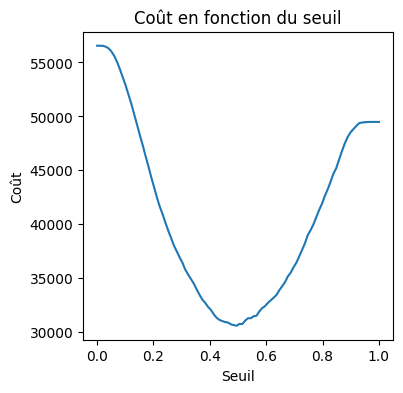

In [55]:
cost_fp = 1  # Coût d'un faux positif
cost_fn = 10  # Coût d'un faux négatif (10 fois le coût d'un faux positif)

y_prob = best_model_lgb_bal.predict_proba(X_test)[:, 1]

best_threshold = 0
min_cost = float('inf')

# Tester différents seuils pour trouver le coût métier minimal
for threshold in np.linspace(0, 1, 100):
    y_pred_threshold = (y_prob > threshold).astype(int)
    cost = custom_cost(y_test, y_pred_threshold, cost_fp, cost_fn)
    if cost < min_cost:
        min_cost = cost
        best_threshold = threshold

# affichage de l'évolution du coût en fonction du seuil
plt.figure(figsize=(4,4))
plt.plot(np.linspace(0, 1, 100), [custom_cost(y_test, (y_prob > threshold).astype(int), cost_fp, cost_fn) for threshold in np.linspace(0, 1, 100)])
plt.xlabel('Seuil')
plt.ylabel('Coût')
plt.title('Coût en fonction du seuil')
plt.show()

In [56]:
print(f"Meilleur seuil: {best_threshold}, Coût minimal: {min_cost}")
# Prédiction sur l'ensemble de test avec le seuil optimisé
y_pred_optimized = (y_prob > best_threshold).astype(int)
# Évaluation avec le seuil optimisé
print_metrics(y_test, y_pred_optimized)

Meilleur seuil: 0.494949494949495, Coût minimal: 30596
Accuracy: 0.7297855389168008
Precision: 0.18394540136496587
Recall: 0.6861992321681147
F1: 0.29012002904617484
ROC AUC: 0.7098994887721077


In [57]:
# obtention des métriques
metrics_optimized = get_metrics(y_test, y_pred_optimized)
# Création d'une nouvelle ligne à ajouter
new_row = pd.DataFrame({'Model': 'LightGBM Balanced Optimized', **metrics_optimized, 'Cost': min_cost, 'Threshold': best_threshold}, index=[0])
# Ajout des résultats de la régression logistique
results = pd.concat([results, new_row], ignore_index=True)
results

,Model,Accuracy,Precision,Recall,F1,ROC_AUC,Cost,Threshold
0,Dummy Classifier,0.919532,0.000000,0.000000,0.000000,0.500000,49490.0,0.500000
1,Logistic Regression,0.919402,0.466667,0.011315,0.022095,0.505092,48994.0,0.500000
2,Logistic Regression Balanced,0.686227,0.159379,0.678319,0.258112,0.682619,33626.0,0.500000
3,LightGBM,0.919971,0.562791,0.024449,0.046863,0.511394,48374.0,0.500000
4,LightGBM Balanced,0.734354,0.185369,0.677915,0.291132,0.708604,30684.0,0.500000
5,LightGBM SMOTE,0.917435,0.347518,0.029703,0.054728,0.512411,48296.0,0.500000
6,LightGBM Balanced Optimized,0.729786,0.183945,0.686199,0.290120,0.709899,30596.0,0.494949


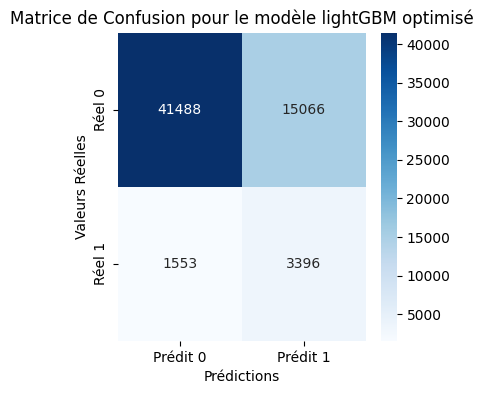

In [58]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Prédiction sur l'ensemble de test avec le seuil optimisé
y_pred_optimized = (y_prob > best_threshold).astype(int)

# Matrice de confusion pour le modèle optimisé
conf_matrix = confusion_matrix(y_test, y_pred_optimized)
#print(conf_matrix)
# Affichage de la matrice de confusion
plt.figure(figsize=(4,4))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=['Prédit 0', 'Prédit 1'], yticklabels=['Réel 0', 'Réel 1'])
plt.xlabel('Prédictions')
plt.ylabel('Valeurs Réelles')
plt.title('Matrice de Confusion pour le modèle lightGBM optimisé')
plt.show()

### Modèle LogisticRegression avec les meilleurs paramètres

In [59]:
# prédictions sur le jeu de test
y_prob_lin = best_model_linear_bal.predict_proba(X_test)[:, 1]

best_threshold = 0
min_cost = float('inf')

# Tester différents seuils pour trouver le coût métier minimal
for threshold in np.linspace(0, 1, 100):
    y_pred_threshold = (y_prob_lin > threshold).astype(int)
    cost = custom_cost(y_test, y_pred_threshold, cost_fp, cost_fn)
    if cost < min_cost:
        min_cost = cost
        best_threshold = threshold

print(f"Meilleur seuil: {best_threshold}, Coût minimal: {min_cost}")

# Prédiction sur l'ensemble de test avec le seuil optimisé
y_pred_optimized_lin = (y_prob_lin > best_threshold).astype(int)

# Évaluation avec le seuil optimisé
print_metrics(y_test, y_pred_optimized_lin)

Meilleur seuil: 0.5555555555555556, Coût minimal: 33387
Accuracy: 0.7509877566947953
Precision: 0.18100689315608076
Recall: 0.5942614669630228
F1: 0.2774920979383875
ROC AUC: 0.6794821144625207


In [60]:
# obtention des métriques
metrics_optimized_lin = get_metrics(y_test, y_pred_optimized_lin)
# Création d'une nouvelle ligne à ajouter
new_row = pd.DataFrame({'Model': 'Logistic Regression Balanced Optimized', **metrics_optimized_lin, 'Cost': min_cost, 'Threshold': best_threshold}, index=[0])
# Ajout des résultats de la régression logistique
results = pd.concat([results, new_row], ignore_index=True)
results

,Model,Accuracy,Precision,Recall,F1,ROC_AUC,Cost,Threshold
0,Dummy Classifier,0.919532,0.000000,0.000000,0.000000,0.500000,49490.0,0.500000
1,Logistic Regression,0.919402,0.466667,0.011315,0.022095,0.505092,48994.0,0.500000
2,Logistic Regression Balanced,0.686227,0.159379,0.678319,0.258112,0.682619,33626.0,0.500000
3,LightGBM,0.919971,0.562791,0.024449,0.046863,0.511394,48374.0,0.500000
4,LightGBM Balanced,0.734354,0.185369,0.677915,0.291132,0.708604,30684.0,0.500000
5,LightGBM SMOTE,0.917435,0.347518,0.029703,0.054728,0.512411,48296.0,0.500000
6,LightGBM Balanced Optimized,0.729786,0.183945,0.686199,0.290120,0.709899,30596.0,0.494949
7,Logistic Regression Balanced Optimized,0.750988,0.181007,0.594261,0.277492,0.679482,33387.0,0.555556


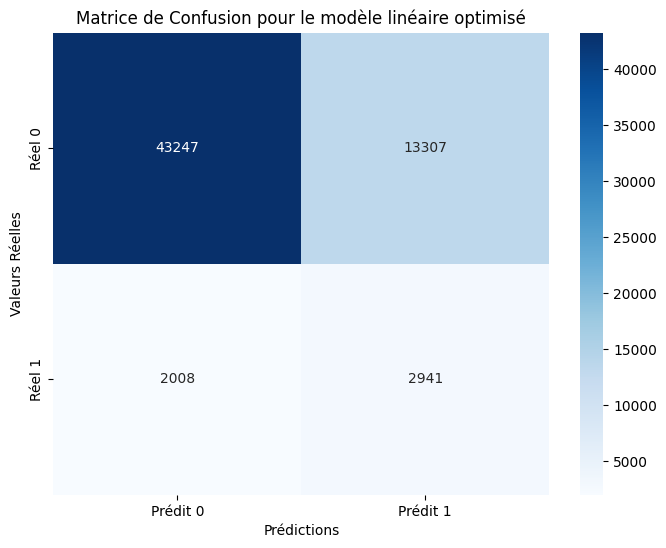

In [61]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Prédiction sur l'ensemble de test avec le seuil optimisé
y_pred_optimized_lin = (y_prob_lin > best_threshold).astype(int)

# Matrice de confusion pour le modèle optimisé
conf_matrix = confusion_matrix(y_test, y_pred_optimized_lin)

# Affichage de la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=['Prédit 0', 'Prédit 1'], yticklabels=['Réel 0', 'Réel 1'])
plt.xlabel('Prédictions')
plt.ylabel('Valeurs Réelles')
plt.title('Matrice de Confusion pour le modèle linéaire optimisé')
plt.show()


## Résultats
L'augmentation observée dans le rappel (recall) du modèle, suite à l'ajustement effectué, suggère une amélioration significative dans l'identification des cas de la classe minoritaire, qui dans ce contexte représente les clients susceptibles de faire défaut. Ce résultat est particulièrement pertinent dans le cadre du scoring de crédit, car il indique une réduction du nombre de faux négatifs. En d'autres termes, le modèle est désormais plus efficace pour détecter les clients à risque qui auraient pu être incorrectement classés comme fiables auparavant.
<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Model</th>
      <th>Accuracy</th>
      <th>Precision</th>
      <th>Recall</th>
      <th>F1</th>
      <th>ROC_AUC</th>
      <th>Cost</th>
      <th>Threshold</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>Dummy Classifier</td>
      <td>0.919532</td>
      <td>0.000000</td>
      <td>0.000000</td>
      <td>0.000000</td>
      <td>0.500000</td>
      <td>49490.0</td>
      <td>0.500000</td>
    </tr>
    <tr>
      <th>1</th>
      <td>Logistic Regression</td>
      <td>0.919402</td>
      <td>0.466667</td>
      <td>0.011315</td>
      <td>0.022095</td>
      <td>0.505092</td>
      <td>48994.0</td>
      <td>0.500000</td>
    </tr>
    <tr>
      <th>2</th>
      <td>Logistic Regression Balanced</td>
      <td>0.686227</td>
      <td>0.159379</td>
      <td>0.678319</td>
      <td>0.258112</td>
      <td>0.682619</td>
      <td>33626.0</td>
      <td>0.500000</td>
    </tr>
    <tr>
      <th>3</th>
      <td>LightGBM</td>
      <td>0.919971</td>
      <td>0.562791</td>
      <td>0.024449</td>
      <td>0.046863</td>
      <td>0.511394</td>
      <td>48374.0</td>
      <td>0.500000</td>
    </tr>
    <tr>
      <th>4</th>
      <td>LightGBM Balanced</td>
      <td>0.734354</td>
      <td>0.185369</td>
      <td>0.677915</td>
      <td>0.291132</td>
      <td>0.708604</td>
      <td>30684.0</td>
      <td>0.500000</td>
    </tr>
    <tr>
      <th>5</th>
      <td>LightGBM SMOTE</td>
      <td>0.917435</td>
      <td>0.347518</td>
      <td>0.029703</td>
      <td>0.054728</td>
      <td>0.512411</td>
      <td>48296.0</td>
      <td>0.500000</td>
    </tr>
    <tr>
      <th>6</th>
      <td>LightGBM Balanced Optimized</td>
      <td>0.729786</td>
      <td>0.183945</td>
      <td>0.686199</td>
      <td>0.290120</td>
      <td>0.709899</td>
      <td>30596.0</td>
      <td>0.494949</td>
    </tr>
    <tr>
      <th>7</th>
      <td>Logistic Regression Balanced Optimized</td>
      <td>0.750988</td>
      <td>0.181007</td>
      <td>0.594261</td>
      <td>0.277492</td>
      <td>0.679482</td>
      <td>33387.0</td>
      <td>0.555556</td>
    </tr>
  </tbody>
</table>
</div>


# SHAP

### Importane des variables de manière globale

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


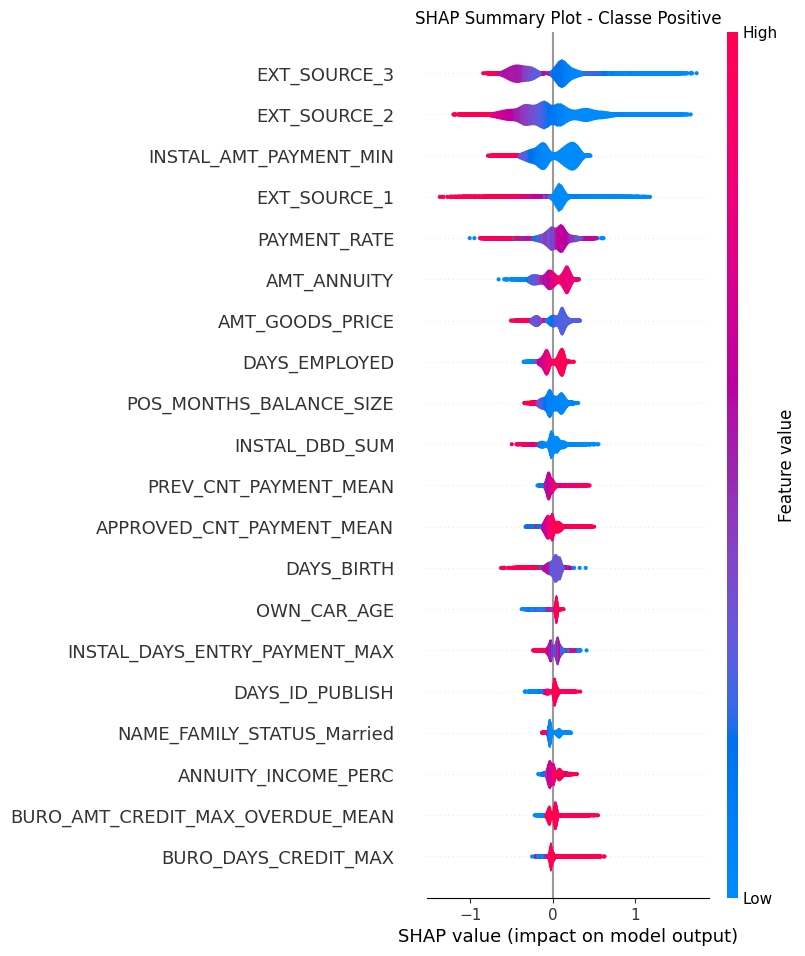

In [62]:
import shap

# Assurez-vous que shap.initjs() est appelé si vous utilisez Jupyter Notebook pour une meilleure visualisation
shap.initjs()

# Création de l'explicateur SHAP pour votre meilleur modèle LightGBM
explainer = shap.TreeExplainer(best_model_lgb_bal)

# Calcul des valeurs SHAP pour l'ensemble de test (X_test)
shap_values = explainer.shap_values(X_test)

# Classe Positive
shap.summary_plot(shap_values[1], X_test, plot_type="violin", show=False)
plt.title("SHAP Summary Plot - Classe Positive")
plt.show()

### Importances locales pour un individu

In [63]:
# création d'une colonne avec les probabilités de défaut de paiement
X_test['TARGET_PROB'] = y_pred_optimized
X_test['TARGET'] = y_test

In [64]:
# Réinitialisation des indices de X_test
X_test_reset = X_test.reset_index(drop=True)

# Sélection des cas et récupération des nouveaux indices
# Cas 1: individu avec un target = 0 et une prédiction = 0
cas_1 = X_test_reset[(X_test_reset['TARGET'] == 0) & (X_test_reset['TARGET_PROB'] == 0)].sample(1)
cas_1_index = cas_1.index[0]

# Cas 2: individu avec un target = 0 et une prédiction = 1
cas_2 = X_test_reset[(X_test_reset['TARGET'] == 0) & (X_test_reset['TARGET_PROB'] == 1)].sample(1)
cas_2_index = cas_2.index[0]

# Cas 3: individu avec un target = 1 et une prédiction = 0
cas_3 = X_test_reset[(X_test_reset['TARGET'] == 1) & (X_test_reset['TARGET_PROB'] == 0)].sample(1)
cas_3_index = cas_3.index[0]

# Cas 4: individu avec un target = 1 et une prédiction = 1
cas_4 = X_test_reset[(X_test_reset['TARGET'] == 1) & (X_test_reset['TARGET_PROB'] == 1)].sample(1)
cas_4_index = cas_4.index[0]


In [65]:
# suppression de la colonne TARGET_PROB et TARGET
X_test.drop(['TARGET_PROB','TARGET'], axis=1, inplace=True)

In [66]:
#paramètres d'affichage
pd.set_option('display.max_columns', 78)
X_test.describe()

,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_EMPLOYED_PERC,DAYS_LAST_PHONE_CHANGE,DAYS_ID_PUBLISH,DAYS_REGISTRATION,REGION_POPULATION_RELATIVE,FLAG_OWN_CAR,FLAG_OWN_REALTY,INCOME_PER_PERSON,INCOME_CREDIT_PERC,ANNUITY_INCOME_PERC,PAYMENT_RATE,AMT_ANNUITY,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,CLOSED_DAYS_CREDIT_ENDDATE_MAX,CLOSED_DAYS_CREDIT_MAX,CLOSED_AMT_CREDIT_SUM_MEAN,ACTIVE_DAYS_CREDIT_ENDDATE_MEAN,ACTIVE_DAYS_CREDIT_ENDDATE_MAX,ACTIVE_DAYS_CREDIT_ENDDATE_MIN,ACTIVE_DAYS_CREDIT_MEAN,ACTIVE_DAYS_CREDIT_UPDATE_MEAN,ACTIVE_AMT_CREDIT_SUM_SUM,BURO_DAYS_CREDIT_ENDDATE_MAX,BURO_DAYS_CREDIT_MAX,BURO_AMT_CREDIT_MAX_OVERDUE_MEAN,APPROVED_CNT_PAYMENT_MEAN,APPROVED_DAYS_DECISION_MAX,PREV_CNT_PAYMENT_MEAN,POS_MONTHS_BALANCE_SIZE,POS_MONTHS_BALANCE_MAX,INSTAL_DBD_MAX,INSTAL_DBD_SUM,INSTAL_DBD_MEAN,INSTAL_AMT_PAYMENT_MIN,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_PAYMENT_DIFF_VAR,OWN_CAR_AGE,OBS_30_CNT_SOCIAL_CIRCLE,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,OCCUPATION_TYPE_nan
count,61503.000000,61503.000000,61503.000000,61503.000000,61503.000000,61503.000000,61503.000000,61503.000000,61503.000000,61503.000000,61503.000000,61503.000000,61503.000000,61503.000000,61503.000000,61503.000000,61503.000000,61503.000000,61503.000000,61503.000000,61503.000000,61503.000000,61503.000000,61503.000000,61503.000000,61503.000000,61503.000000,61503.000000,61503.000000,61503.000000,61503.000000,61503.000000,61503.000000,61503.000000,61503.000000,61503.000000,61503.000000,61503.000000,61503.000000,61503.000000,61503.000000,61503.000000,61503.000000,61503.000000,61503.000000,61503.000000,61503.000000,61503.000000,61503.000000,61503.000000,61503.000000,61503.000000,61503.000000,61503.000000,61503.000000,61503.000000,61503.000000,61503.000000,61503.000000,61503.000000,61503.000000,61503.000000,61503.000000,61503.000000,61503.000000,61503.000000,61503.000000,61503.000000,61503.000000,61503.000000,61503.000000,61503.000000,61503.000000,61503.000000,61503.000000
mean,0.002223,-0.001336,0.156904,-0.001085,-0.004062,-0.001288,0.020921,0.337577,0.690519,0.010067,0.373325,0.000786,0.053755,-0.004019,-0.007861,0.016215,0.501550,0.514425,0.510272,-0.004962,-0.005025,-0.000639,0.001539,0.001728,0.001723,-0.000789,-0.001044,-0.006359,0.002917,0.000184,0.000905,-0.001152,-0.005419,-0.000629,0.000281,-0.003559,0.001474,-0.001146,-0.002123,-0.000959,0.001732,-0.001829,0.004605,-0.002394,0.003496,0.885794,0.037673,0.008536,0.015690,0.048811,0.096467,0.635936,0.064468,0.149163,0.000016,0.053949,0.031950,0.015137,0.020454,0.089882,0.060436,0.001886,0.035771,0.001870,0.178609,0.007089,0.068387,0.027966,0.008731,0.002520,0.105361,0.004000,0.021885,0.004504,0.313562
std,1.003121,0.997605,0.120788,0.994997,1.001218,1.002124,0.013884,0.472887,0.462283,2.366680,0.235744,0.995905,0.022480,0.994151,0.991777,4.661514,0.139591,0.190886,0.174580,1.035601,1.003877,1.537743,1.003924,1.009106,0.976464,1.010958,0.949620,0.839360,1.005400,1.000031,0.811551,1.005092,1.002124,1.002176,0.999138,0.999784,1.012136,0.997671,1.002398,0.950287,0.994813,0.992436,1.007947,1.000410,0.059022,0.318064,0.190406,0.091997,0.

In [67]:
def visualize_shap_for_class_1(index, model, X_test, shap_values, target_real, explainer):
    """
    Affiche les informations et le graphique SHAP waterfall pour la classe 1 d'une instance spécifique.

    Parameters:
    index (int): Index de l'instance à visualiser.
    model (Model): Modèle utilisé pour la prédiction.
    X_test (DataFrame): Ensemble de données de test.
    shap_values (array): Valeurs SHAP calculées pour X_test.
    target_real (array): Valeurs réelles de la cible.
    explainer (shap.Explainer): Explainer SHAP utilisé pour le modèle.
    """
    # Prédiction du modèle pour l'instance spécifique
    predicted_proba = model.predict_proba(X_test.iloc[index:index+1])[0]

    # Affichage des probabilités des deux classes
    print(f"Index: {index}")
    print(f"Probabilité de la classe 0: {predicted_proba[0]:.3f}")
    print(f"Probabilité de la classe 1: {predicted_proba[1]:.3f}")
    print(f"Classe réelle: {target_real.iloc[index]}")

    # Calcul de la valeur f(x) pour la classe 1
    shap_values_instance = shap_values[1][index]
    fx = explainer.expected_value[1] + shap_values_instance.sum()

    print(f"Valeur f(x) brute pour la classe 1: {fx:.3f}")

    # Création de l'objet Explanation pour l'instance spécifique (classe 1)
    shap_values_obj = shap.Explanation(values=shap_values_instance,
                                       base_values=explainer.expected_value[1],
                                       data=X_test.iloc[index],
                                       feature_names=X_test.columns.tolist())

    # Affichage du graphique waterfall pour la classe 1
    shap.plots.waterfall(shap_values_obj, max_display=10)

Index: 19073
Probabilité de la classe 0: 0.832
Probabilité de la classe 1: 0.168
Classe réelle: 0
Valeur f(x) brute pour la classe 1: -1.600


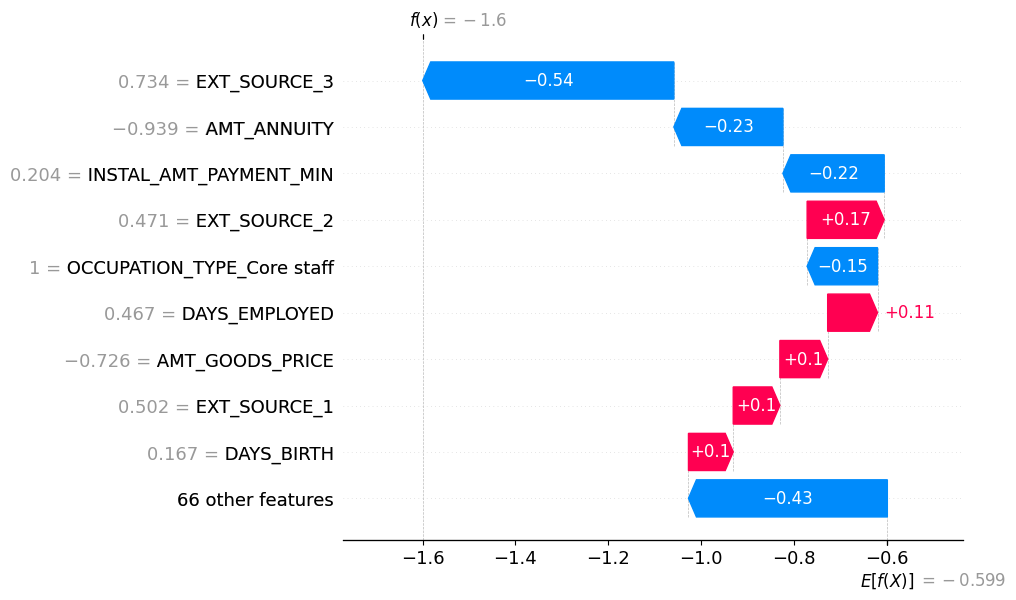

Index: 16011
Probabilité de la classe 0: 0.257
Probabilité de la classe 1: 0.743
Classe réelle: 0
Valeur f(x) brute pour la classe 1: 1.063


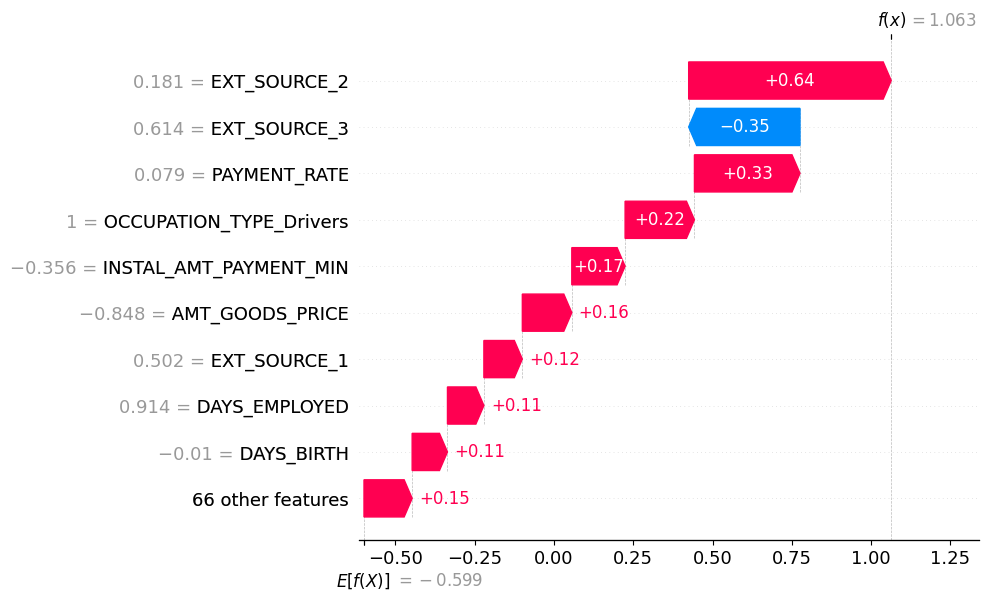

Index: 14674
Probabilité de la classe 0: 0.586
Probabilité de la classe 1: 0.414
Classe réelle: 1
Valeur f(x) brute pour la classe 1: -0.348


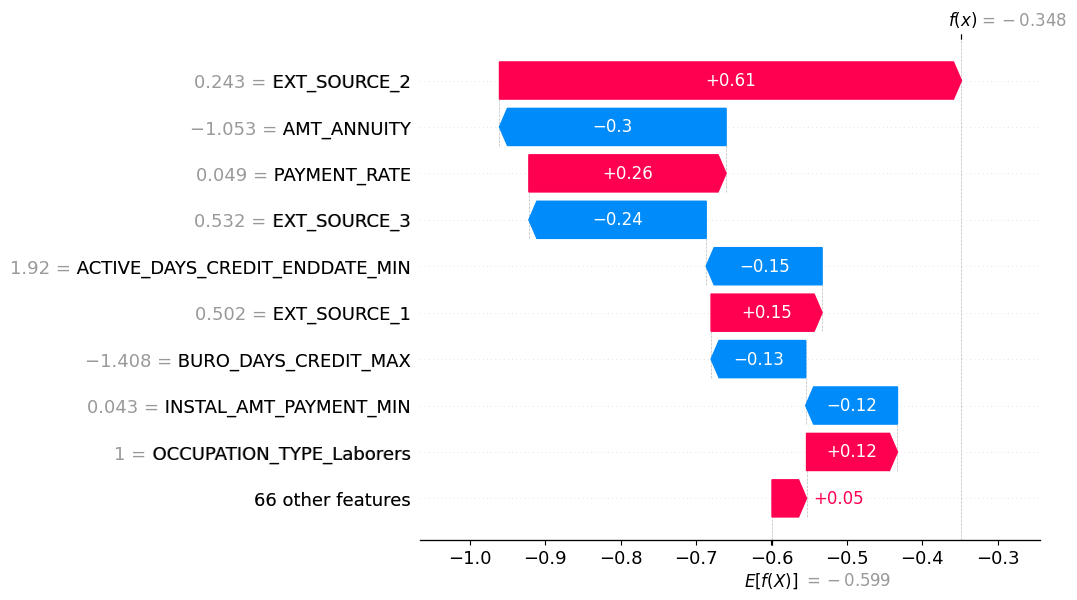

Index: 12068
Probabilité de la classe 0: 0.241
Probabilité de la classe 1: 0.759
Classe réelle: 1
Valeur f(x) brute pour la classe 1: 1.146


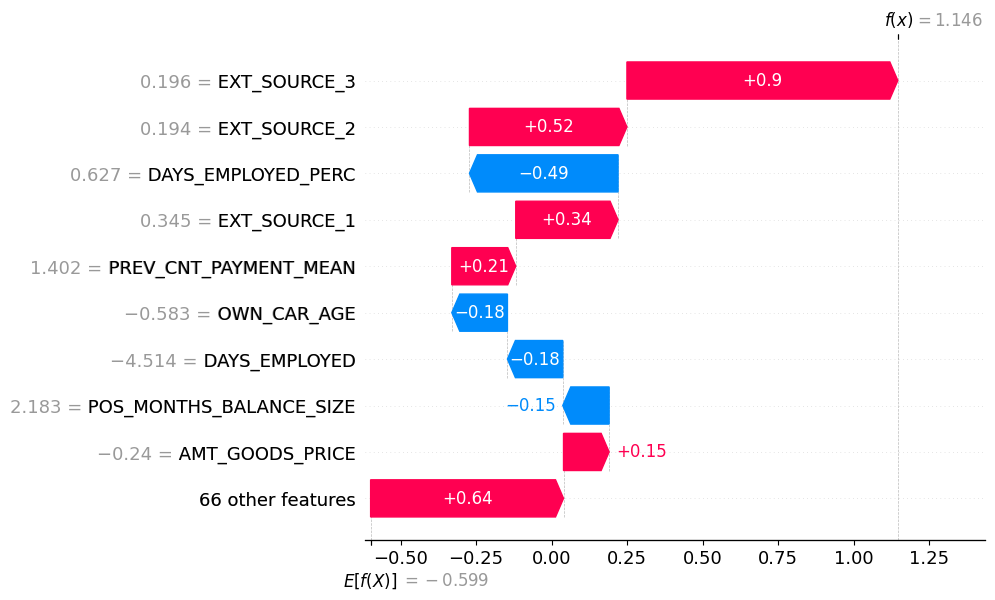

In [68]:
for index in [cas_1_index, cas_2_index, cas_3_index, cas_4_index]:
    visualize_shap_for_class_1(index, best_model_lgb_bal, X_test, shap_values, y_test, explainer)

# MLFLOW Tracking experiment

In [69]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def print_metrics(y_true, y_pred):
    print("Accuracy: {}".format(accuracy_score(y_true, y_pred)))
    print("Precision: {}".format(precision_score(y_true, y_pred)))
    print("Recall: {}".format(recall_score(y_true, y_pred)))
    print("F1: {}".format(f1_score(y_true, y_pred)))
    print("ROC AUC: {}".format(roc_auc_score(y_true, y_pred)))

In [70]:
import mlflow
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV

# Initialisation de MLflow
mlflow.set_experiment("Projet 7: Best Model")

# Démarrage du suivi MLflow
with mlflow.start_run():

    # Création du modèle LightGBM avec rééquilibrage des classes
    model = LGBMClassifier(objective='binary', class_weight='balanced', metric='binary_error', verbose=-1)

    # Paramètres pour le GridSearchCV
    param_grid = {
        'n_estimators': [800, 900, 1000],
        'learning_rate': [0.02],
    }

    # GridSearchCV pour la recherche des meilleurs paramètres
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc')
    grid_search.fit(X_train, y_train)

    # Meilleurs paramètres et score
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    print("Meilleurs paramètres : ", best_params)
    print("Meilleur score : ", best_score)

    # Log des hyperparamètres et du meilleur score dans MLflow
    mlflow.log_params(best_params)
    mlflow.log_metric("best_score_roc_auc", best_score)

    # Enregistrement du modèle dans MLflow model_registry
    best_model_lgb_bal = grid_search.best_estimator_
    mlflow.sklearn.log_model(best_model_lgb_bal, "model_artifact", registered_model_name="Projet_7_LGBM_Balanced_optimized")

    # Prédiction et évaluation avec le modèle sélectionné
    y_pred_lgb_bal = best_model_lgb_bal.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred_lgb_bal)
    auc = roc_auc_score(y_test, y_pred_lgb_bal)
    print("Accuracy: ", accuracy)
    print("AUC: ", auc)

    # Log des métriques dans MLflow
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("auc", auc)

# Test des différents seuils pour optimiser le score métier
cost_fp = 1  # Coût d'un faux positif
cost_fn = 10  # Coût d'un faux négatif

y_prob_lin = best_model_lgb_bal.predict_proba(X_test)[:, 1]

best_threshold = 0
min_cost = float('inf')

# Tester différents seuils pour trouver le coût métier minimal
for threshold in np.linspace(0, 1, 100):
    y_pred_threshold = (y_prob_lin > threshold).astype(int)
    cost = custom_cost(y_test, y_pred_threshold, cost_fp, cost_fn)
    if cost < min_cost:
        min_cost = cost
        best_threshold = threshold

# Log du meilleur seuil et du coût associé dans MLflow
mlflow.log_metric("best_threshold", best_threshold)
mlflow.log_metric("min_cost", min_cost)

# recalcul des métriques avec le seuil optimisé
y_pred_optimized_lin = (y_prob_lin > best_threshold).astype(int)
accuracy = accuracy_score(y_test, y_pred_optimized_lin)
auc = roc_auc_score(y_test, y_pred_optimized_lin)
mlflow.log_metric("accuracy_optimized", accuracy)
mlflow.log_metric("auc_optimized", auc)


print(f"Meilleur seuil: {best_threshold}, Coût minimal: {min_cost}")
print_metrics(y_test, y_pred_optimized_lin)
# Fin de l'exécution MLflow
mlflow.end_run()

Meilleurs paramètres :  {'learning_rate': 0.02, 'n_estimators': 1000}
Meilleur score :  0.7725099958498246


Registered model 'Projet_7_LGBM_Balanced_optimized' already exists. Creating a new version of this model...
Created version '2' of model 'Projet_7_LGBM_Balanced_optimized'.


Accuracy:  0.7343544217355251
AUC:  0.7086040744640136
Meilleur seuil: 0.494949494949495, Coût minimal: 30596
Accuracy: 0.7297855389168008
Precision: 0.18394540136496587
Recall: 0.6861992321681147
F1: 0.29012002904617484
ROC AUC: 0.7098994887721077


In [71]:
import mlflow.pyfunc

class LGBMClassifierWithThreshold(mlflow.pyfunc.PythonModel):

    def __init__(self, model, threshold):
        self.model = model
        self.threshold = threshold

    def predict(self, context, model_input):
        # Prédiction des probabilités
        probas = self.model.predict_proba(model_input)[:, 1]
        # Application du seuil métier
        return (probas > self.threshold).astype(int)

In [72]:
# Création de l'instance de classe de modèle personnalisée
model_with_threshold = LGBMClassifierWithThreshold(best_model_lgb_bal, best_threshold)
# Log du modèle avec MLflow
mlflow.pyfunc.log_model("model_with_threshold", python_model=model_with_threshold)

Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
Setuptools is replacing distutils.


In [73]:
import mlflow
logged_model = 'runs:/b8b16490de224bf7bc2c3701a994af26/model_with_threshold'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

# Predict on a Pandas DataFrame.
import pandas as pd
loaded_model.predict(pd.DataFrame(X_test))

print_metrics(y_test, loaded_model.predict(pd.DataFrame(X_test)))

Accuracy: 0.7297855389168008
Precision: 0.18394540136496587
Recall: 0.6861992321681147
F1: 0.29012002904617484
ROC AUC: 0.7098994887721077
